In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt


In [ ]:
work_path = '/content/gdrive/Shared drives/marketdata/stock/'
os.chdir(work_path)

### Define Parameters

In [ ]:
STOP_PROFIT = 1
STOP_LOSS = 2
TIME_OUT = 3

In [ ]:
def numtotime(num):
    ms = num % 1000
    num //= 1000
    s = num % 100
    num //= 100
    mi = num % 100
    num //= 100
    h = num % 100
    num = num // 100
    # print(h, mi, s, ms)
    return dt.datetime(2020, 9, 21, h, mi, s, ms) # TODO

# Hft_strategy

In [ ]:
class Hft_strategy:
    def __init__(self, lob_file, tick_file):
        self.lob_file = open(lob_file)
        self.tick_file = open(tick_file)
        self.df = pd.read_csv(tick_file)
        self.df["time"] = self.df["time"].apply(func = numtotime)
        self.df.set_index("time", inplace = True)
        self.lob_col = self.lob_file.readline()[:-1].split(",")
        self.tick_col = self.tick_file.readline()[:-1].split(",")
        self.ref_num = 0
        self.num_buy = 0
        self.num_sell = 0
        self.ask1_p = 0
        self.ask2_p = 0
        self.ask3_p = 0
        self.ask4_p = 0
        self.ask5_p = 0
        self.ask1_q = 0
        self.ask2_q = 0
        self.ask3_q = 0
        self.ask4_q = 0
        self.ask5_q = 0
        self.bid1_p = 0
        self.bid2_p = 0
        self.bid3_p = 0
        self.bid4_p = 0
        self.bid5_p = 0
        self.bid1_q = 0
        self.bid2_q = 0
        self.bid3_q = 0
        self.bid4_q = 0
        self.bid5_q = 0
        self.daily_high = 0
        self.daily_low = 10000

        self.stop_profit = 0
        self.stop_loss = 0

        self.profit = 0
        self.cost = 0

        self.num_win = 0
        self.num_loss = 0

        self.order_time = 0
        self.stop_time = None

        self.position = []
        self.current_time = 0

        self.total_cost = 0

    def get_result(self):
        return self.profit, self.total_cost, self.num_win, self.num_loss

    def lob_update(self, lob_row):
        pass

    def tick_update(self, tick_row):
        pass

    def could_buy(self):
        pass

    def buy(self):
        pass

    def could_sell(self):
        pass

    def sell(self):
        pass

    def could_order(self):
        pass
        
    def order(self):
        pass

    def task(self):
        pass

    def show_result(self):
        pass

    def save_result_and_parameters(self, path):
        


# YY8
### 多了偵測賣壓
### bid3_p買回
#### self.bid1_p > self.weighted_p * self.theta
#### self.num_sell > self.num_buy * self.beta



In [ ]:
class YY8(Hft_strategy):
    def __init__(self, lob_file, tick_file, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q):
        super().__init__(lob_file, tick_file)
        self.tick_list = []
        self.beta = beta
        self.time_out = time_out
        self.order_p = np.array([])
        self.gamma = gamma
        self.in_history = []
        self.out_history = []
        self.in_time = []
        self.out_time = []
        self.cool_down_min = cool_down_min
        self.stop_loss_factor = stop_loss_factor
        self.theta = theta
        self.weighted_p = 0
        self.total_trade_q = 0
        self.total_trade_p = 0
        self.position_max_q = position_max_q
        self.position = np.array([])

        print(self.lob_file)
        print(self.tick_file)


    def task(self):
        temp_lob = self.lob_file.readline()[:-1].split(",")
        temp_tick = self.tick_file.readline()[:-1].split(",")
        lob_row = pd.Series(data = temp_lob, index=self.lob_col)
        tick_row = pd.Series(data = temp_tick, index = self.tick_col)
        self.lob_datatype_conversion(lob_row)
        self.tick_datatype_conversion(tick_row)
        next_lob_time = lob_row['time']
        next_tick_time = tick_row['time']
        self.current_time = min(next_lob_time, next_tick_time)
        print(self.current_time)

        c = 0
        flag = 1
        while(self.current_time <= 130000000):
            # print(c)
            c += 1                        
            if (next_lob_time < next_tick_time):
                self.lob_update(lob_row)
                temp_lob = self.lob_file.readline()[:-1].split(",")
                lob_row = pd.Series(data = temp_lob, index=self.lob_col)
                self.lob_datatype_conversion(lob_row)
                next_lob_time = lob_row['time']
            else:
                self.tick_update(tick_row)
                temp_tick = self.tick_file.readline()[:-1].split(",")
                tick_row = pd.Series(data = temp_tick, index = self.tick_col)
                self.tick_datatype_conversion(tick_row)
                next_tick_time = tick_row['time']
            # print("next_lob: ", next_lob_time, "next_tick: ", next_tick_time)
            self.current_time = min(next_lob_time, next_tick_time)
            if self.could_sell():
                self.sell()
            if self.could_buy(tick_row):
                self.buy(tick_row)
            '''
            buy_type = self.could_buy(tick_row)
            if buy_type == STOP_PROFIT:
                self.buy()
                print("出場時間：", self.current_time)
                self.out_time.append(self.current_time)
                print("buy at", self.order_p)
                print("get", -self.order_p + self.cost)
                self.out_history.append(self.order_p)
                self.profit += self.cost - self.order_p 
                print("-"*30)
            elif buy_type == STOP_LOSS or buy_type == TIME_OUT:
                self.buy()
                print("出場時間：", self.current_time)
                self.out_time.append(self.current_time)
                print("buy at", self.ask1_p)
                print("get", -self.ask1_p + self.cost)
                self.out_history.append(self.ask1_p)
                self.profit += -self.ask1_p + self.cost
                print("-"*30)
            '''
        self.clear_position(tick_row)

    
    def lob_datatype_conversion(self, lob_row):
        lob_row['time'] = int(lob_row['time'])
        lob_row['ask1_price'] = float(lob_row['ask1_price'])
        lob_row['ask2_price'] = float(lob_row['ask2_price'])
        lob_row['ask3_price'] = float(lob_row['ask3_price'])
        lob_row['ask4_price'] = float(lob_row['ask4_price'])
        lob_row['ask5_price'] = float(lob_row['ask5_price'])
        lob_row['bid1_price'] = float(lob_row['bid1_price'])
        lob_row['bid2_price'] = float(lob_row['bid2_price'])
        lob_row['bid3_price'] = float(lob_row['bid3_price'])
        lob_row['bid4_price'] = float(lob_row['bid4_price'])
        lob_row['bid5_price'] = float(lob_row['bid5_price'])
        lob_row['ask1_qty'] = int(float(lob_row['ask1_qty']))
        lob_row['ask2_qty'] = int(float(lob_row['ask2_qty']))
        lob_row['ask3_qty'] = int(float(lob_row['ask3_qty']))
        lob_row['ask4_qty'] = int(float(lob_row['ask4_qty']))
        lob_row['ask5_qty'] = int(float(lob_row['ask5_qty']))
        lob_row['bid1_qty'] = int(float(lob_row['bid1_qty']))
        lob_row['bid2_qty'] = int(float(lob_row['bid2_qty']))
        lob_row['bid3_qty'] = int(float(lob_row['bid3_qty']))
        lob_row['bid4_qty'] = int(float(lob_row['bid4_qty']))
        lob_row['bid5_qty'] = int(float(lob_row['bid5_qty']))

    def tick_datatype_conversion(self, tick_row):
        tick_row['time'] = int(tick_row['time'])
        tick_row['price'] = float(tick_row['price'])
        tick_row['qty'] = int(tick_row['qty'])

    def lob_update(self, lob_row):
        self.ask1_p = lob_row['ask1_price'] 
        self.ask2_p = lob_row['ask2_price']
        self.ask3_p = lob_row['ask3_price']
        self.ask4_p = lob_row['ask4_price']
        self.ask5_p = lob_row['ask5_price']
        self.ask1_q = lob_row['ask1_qty']
        self.ask2_q = lob_row['ask2_qty']
        self.ask3_q = lob_row['ask3_qty']
        self.ask4_q = lob_row['ask4_qty']
        self.ask5_q = lob_row['ask5_qty']
        self.bid1_p = lob_row['bid1_price']
        self.bid2_p = lob_row['bid2_price']
        self.bid3_p = lob_row['bid3_price']
        self.bid4_p = lob_row['bid4_price']
        self.bid5_p = lob_row['bid5_price']
        self.bid1_q = lob_row['bid1_qty']
        self.bid2_q = lob_row['bid2_qty']
        self.bid3_q = lob_row['bid3_qty']
        self.bid4_q = lob_row['bid4_qty']
        self.bid5_q = lob_row['bid5_qty']

    def tick_update(self, tick_row):
        self.daily_low = min(self.daily_low, tick_row['price'])
        self.daily_high = max(self.daily_high, tick_row['price'])
        if self.current_time > 90100000:
            self.total_trade_q += tick_row['qty'] 
            self.total_trade_p += tick_row['price'] * tick_row['qty'] 
            self.weighted_p = self.total_trade_p / self.total_trade_q

        if (tick_row['price'] >= self.ask1_p):
            tick_row['buy_or_sell'] = "buy"
            self.num_buy += tick_row['qty'] 
        elif (tick_row['price'] <= self.bid1_p):
            tick_row['buy_or_sell'] = "sell"
            self.num_sell += tick_row['qty']
        else:
            tick_row['buy_or_sell'] = "QAO"
            print("------Weird price!!!!!---------")
            print("At time: ", tick_row['time'])
            print("tick_row_price", tick_row['price'])
            print("ask_1_p", self.ask1_p)
            print("bid_1_p", self.bid1_p)
            # assert(0), "Weird price!!!!!"

        if len(self.tick_list) < 10:
            self.tick_list.append(tick_row)
        else:
            if self.tick_list[0]['buy_or_sell'] == "buy":
                self.num_buy -= self.tick_list[0]['qty']
            elif self.tick_list[0]['buy_or_sell'] == "sell":
                self.num_sell -= self.tick_list[0]['qty']
            else:
                pass
            self.tick_list.pop(0)
            self.tick_list.append(tick_row)

    def could_sell(self):
        if self.bid1_p > self.weighted_p * self.theta \
            and self.current_time >= self.order_time + self.cool_down_min \
            and len(self.position) <= self.position_max_q \
            and self.current_time > 90200000\
            and self.num_sell > self.num_buy * self.beta:
            print("*** bid1_p: ", self.bid1_p)
            print("*** weighted_p: ", self.weighted_p)
            print("ask1_p: ", self.ask1_p)
            return True
        else:
            return False

    def sell(self):
        print("進場時間：", self.current_time, "\n  sell price at ", self.bid1_p)
        self.in_history.append(self.bid1_p)
        self.in_time.append(self.current_time)
        self.position = np.append(self.position, self.bid1_p)
        self.order_time = self.current_time
        self.cost = self.bid1_p
        self.order_p = np.append(self.order_p, self.bid3_p)

        self.total_cost += self.cost

    def could_buy(self, tick_row):
        # stop profit
        if len(self.position) and tick_row['price'] <= np.max(self.order_p):
            print("stop profit")
            return STOP_PROFIT
        # stop loss
        return False
        # elif len(self.position) and tick_row['price'] >= self.cost * self.stop_loss_factor:
        #     print("stop loss")
        #     return STOP_LOSS
        # # time out
        # elif len(self.position) and self.current_time - self.order_time >= self.time_out:
        #     print("time out")
        #     return False
        # else:
        #     return False
        # keep position

        # no position

    def buy(self, tick_row):
        print("出場時間：", self.current_time)
        self.out_history.append(tick_row['price'])
        self.out_time.append(self.current_time)
        print("POSITION(pre): ", self.position)
        print("Order_p(pre): ", self.order_p)
        print("tick_row price: ", tick_row['price'])
        buy_index = np.argwhere(self.order_p >= tick_row['price'])
        print("qualified index: ", buy_index)
        self.profit += (self.position-self.order_p)[buy_index].sum()
        self.position = np.delete(self.position, buy_index)
        self.order_p = np.delete(self.order_p, buy_index)
        print("POSITION(post): ", self.position)
        print("Order_p(post): ", self.order_p)
        print()

        # self.order_time = self.current_time
        
    def clear_position(self, tick_row):
        print("clear_position: ", np.sum(self.position-tick_row["price"]))
        print("position: ", self.position)
        print("tick_row_price", tick_row["price"])
        self.profit += np.sum(self.position-tick_row["price"])
            

    def show_result(self):
        print("----------Result Report--------------")
        print("profit: ", self.profit)
        plt.figure(figsize=(20,10))
        plt.subplot(211)
        plt.title("price")
        
        plt.scatter([numtotime(x) for x in self.in_time], self.in_history, marker='v', s= 144, c="red")
        plt.scatter([numtotime(x) for x in self.out_time], self.out_history, marker='^', s = 144, c="lime")
        plt.plot(self.df.index, self.df.loc[:, 'price'])
        plt.subplot(212)
        #plt.figure(figsize=(20,10))
        plt.title("qty")
        plt.plot(self.df.index, self.df.loc[:, "qty"])
        
        plt.show()



In [ ]:
import datetime as dt


def back_test(start_date, end_date, sid, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q):
    
    cur_day = None
    result_list = []
    for file in sorted(os.listdir()):
        if "zip" not in file:
            # print(file)
            year, month, date = [int(x) for x in file.split("-")]

            cur_day = dt.datetime(year, month, date)
            if end_date >= cur_day >= start_date:
                sid_type = "otc"
                lob_path = os.path.join(work_path, file, sid, sid_type + "_lob_" + sid + ".csv")
                tick_path = os.path.join(work_path, file, sid, sid_type + "_tick_" + sid + ".csv")

                if not os.path.exists(lob_path):
                    sid_type = "tse"
                    lob_path = os.path.join(work_path, file, sid, sid_type + "_lob_" + sid + ".csv")
                    tick_path = os.path.join(work_path, file, sid, sid_type + "_tick_" + sid + ".csv")
                temp = YY8(lob_path, tick_path, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q)
                temp.task()
                result_list.append(temp.get_result())
                temp.show_result()
                with open("../result.csv", "a") as f:
                    f.write("\n")
                    f.write(",".join([str(x) for x in ["YY8", cur_day, sid, beta, time_out, gamma, \
                                                    cool_down_min, stop_loss_factor, theta, position_max_q, temp.profit, temp.total_cost]]))
                    
    return result_list 

def calculate_profit(res_list):
    s = 0
    c = 0
    for x in res_list:
        s+=x[0]
        c+=x[1]
    return s, c


#### RUN

#### 1301

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90011511
*** bid1_p:  78.7
*** weighted_p:  78.50030674846599
ask1_p:  78.8
進場時間： 95050548 
  sell price at  78.7
*** bid1_p:  78.7
*** weighted_p:  78.50068859984671
ask1_p:  78.8
進場時間： 95206580 
  sell price at  78.7
stop profit
出場時間： 95702462
POSITION(pre):  [78.7 78.7]
Order_p(pre):  [78.5 78.5]
tick_row price:  78.5
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  78.8
*** weighted_p:  78.54986062717781
ask1_p:  78.9
進場時間： 124814682 
  sell price at  78.8
*** bid1_p:  78.8
*** weighted_p:  78.55081568899696
ask1_p:  78.9
進場時間： 124917431 
  sell price at  78.8
*** bid1_p:  78.8
*** weighted_p:  78.55090215128392
ask1_p:  78.9
進場時間： 125024333 
  sell price at  78.8
*** bid1_p:  78.8
*** w

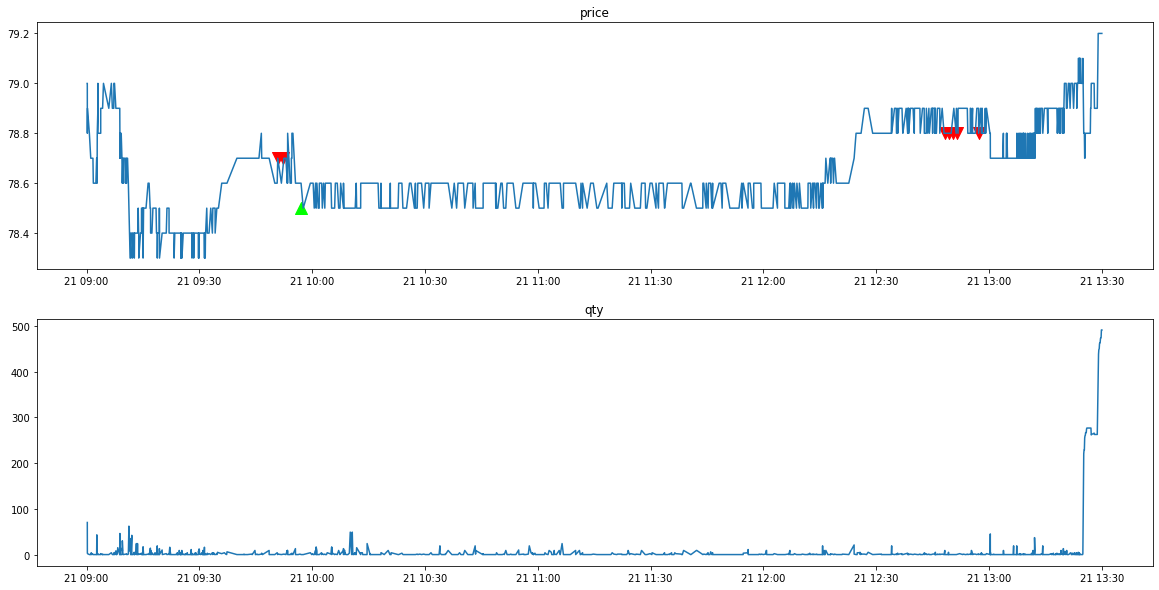

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90011329
clear_position:  0.0
position:  []
tick_row_price 78.8
----------Result Report--------------
profit:  0.0


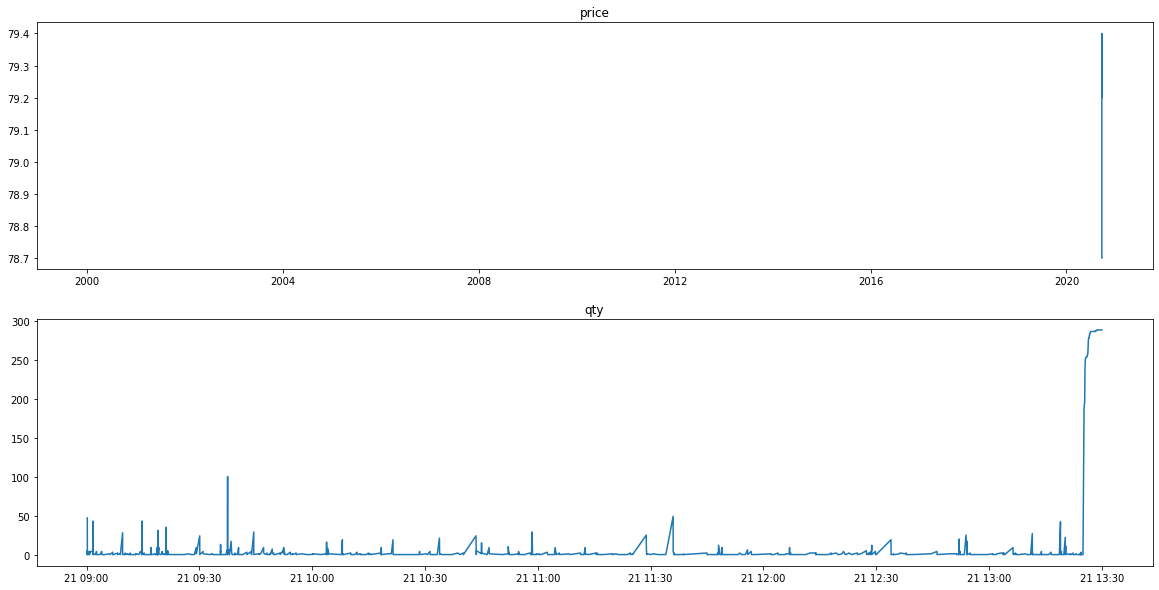

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90013368
clear_position:  0.0
position:  []
tick_row_price 78.3
----------Result Report--------------
profit:  0.0


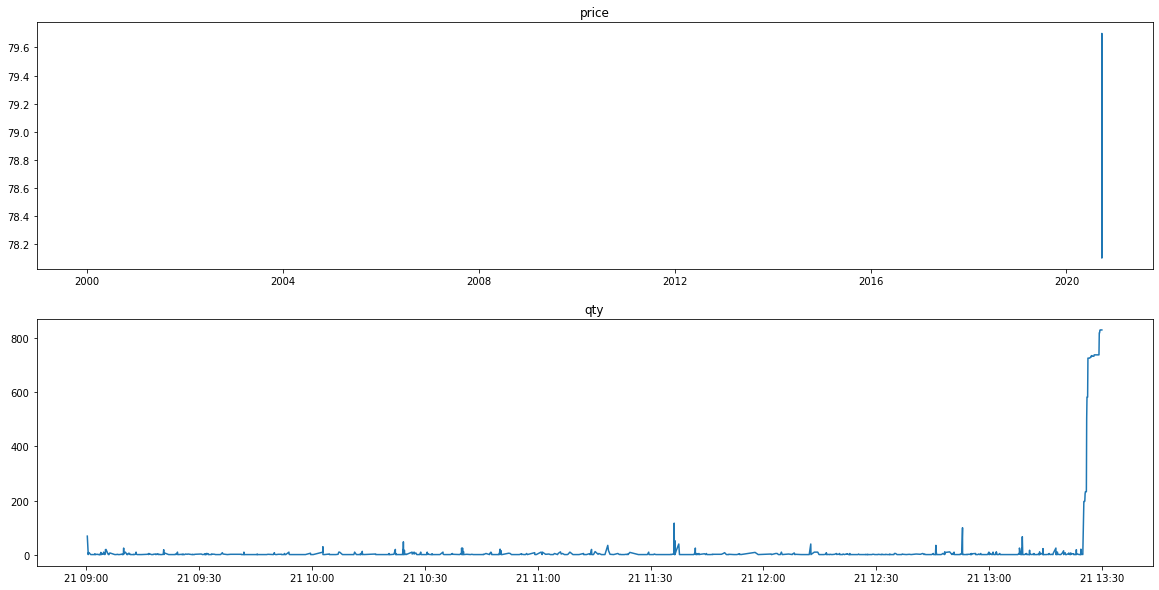

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90012136
clear_position:  0.0
position:  []
tick_row_price 79.1
----------Result Report--------------
profit:  0.0


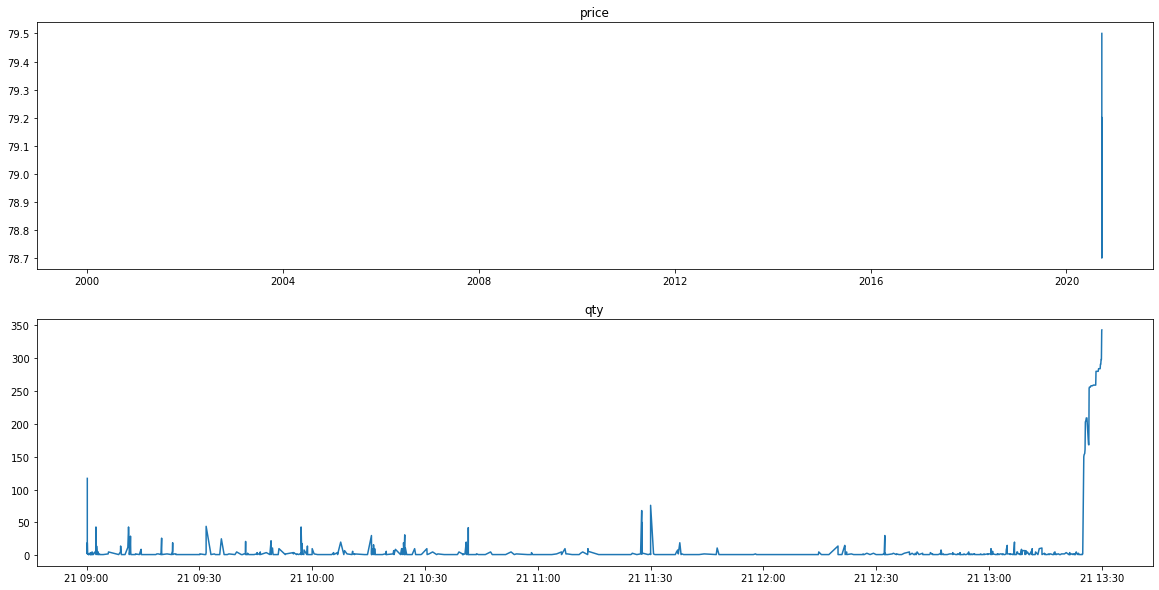

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90012290
clear_position:  0.0
position:  []
tick_row_price 78.8
----------Result Report--------------
profit:  0.0


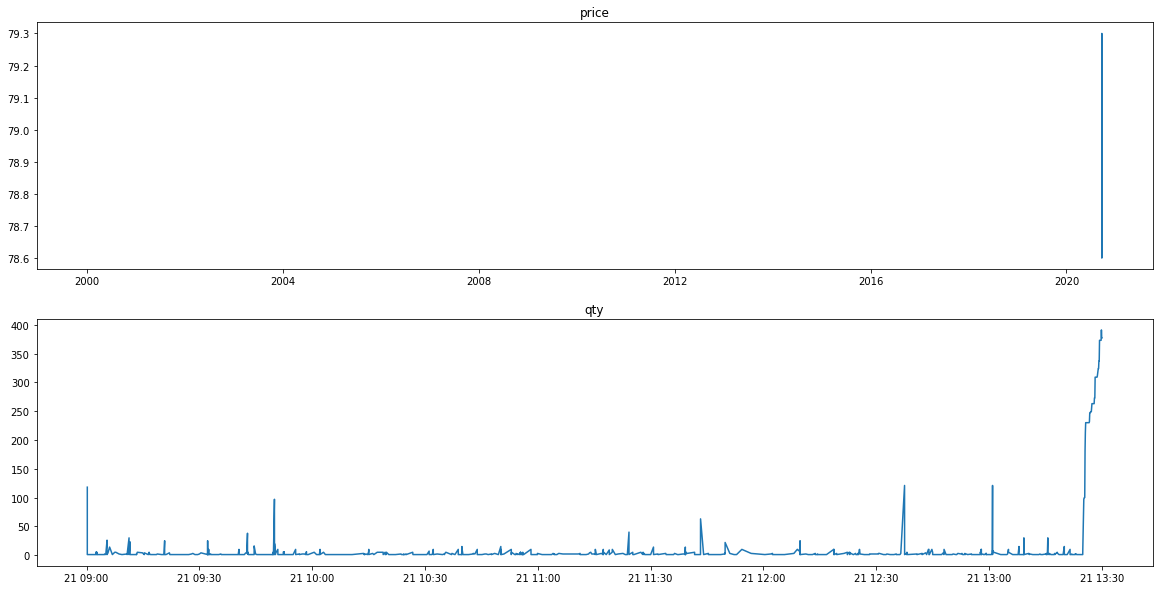

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90012153
clear_position:  0.0
position:  []
tick_row_price 79.0
----------Result Report--------------
profit:  0.0


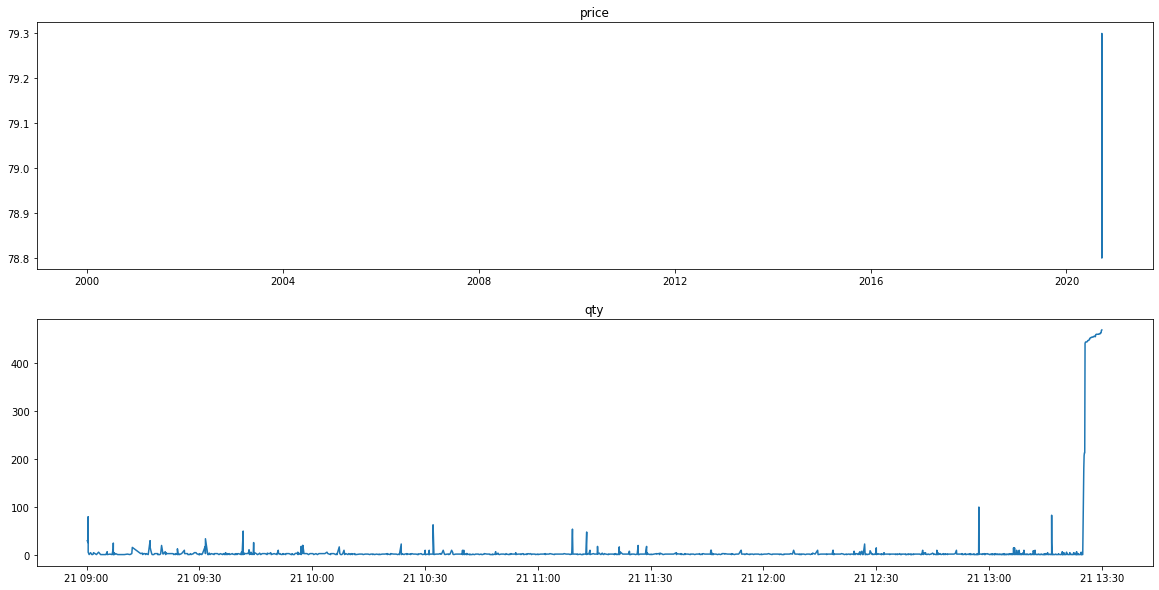

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90011031
clear_position:  0.0
position:  []
tick_row_price 78.3
----------Result Report--------------
profit:  0.0


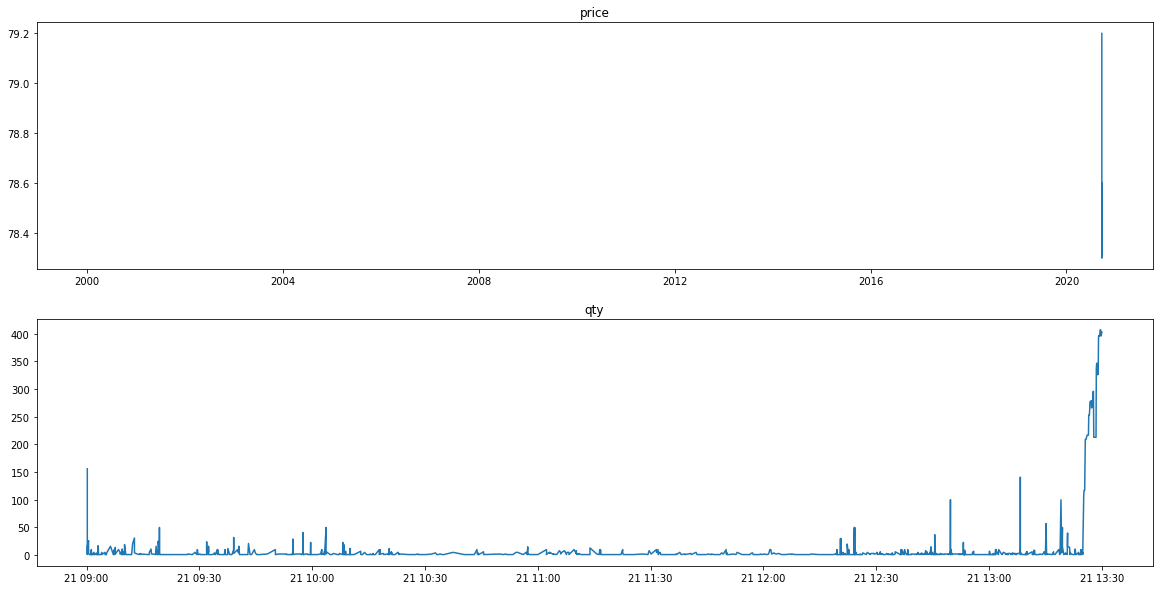

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90012499
*** bid1_p:  80.1
*** weighted_p:  79.87325581395349
ask1_p:  80.2
進場時間： 90315684 
  sell price at  80.1
*** bid1_p:  81.0
*** weighted_p:  80.26572769953047
ask1_p:  81.3
進場時間： 90425609 
  sell price at  81.0
------Weird price!!!!!---------
At time:  90429722
tick_row_price 81.0
ask_1_p 81.1
bid_1_p 80.9
*** bid1_p:  81.0
*** weighted_p:  80.46199095022625
ask1_p:  81.1
進場時間： 90533263 
  sell price at  81.0
stop profit
出場時間： 90600943
POSITION(pre):  [80.1 81.  81. ]
Order_p(pre):  [79.9 80.8 80.8]
tick_row price:  80.8
qualified index:  [[1]
 [2]]
POSITION(post):  [80.1]
Order_p(post):  [79.9]

*** bid1_p:  80.8
*** weighted_p:  80.49694585839873
ask1_p:  80.9
進場時間： 90635210 
  sell price at  80.8
*** bid1_p:  81.

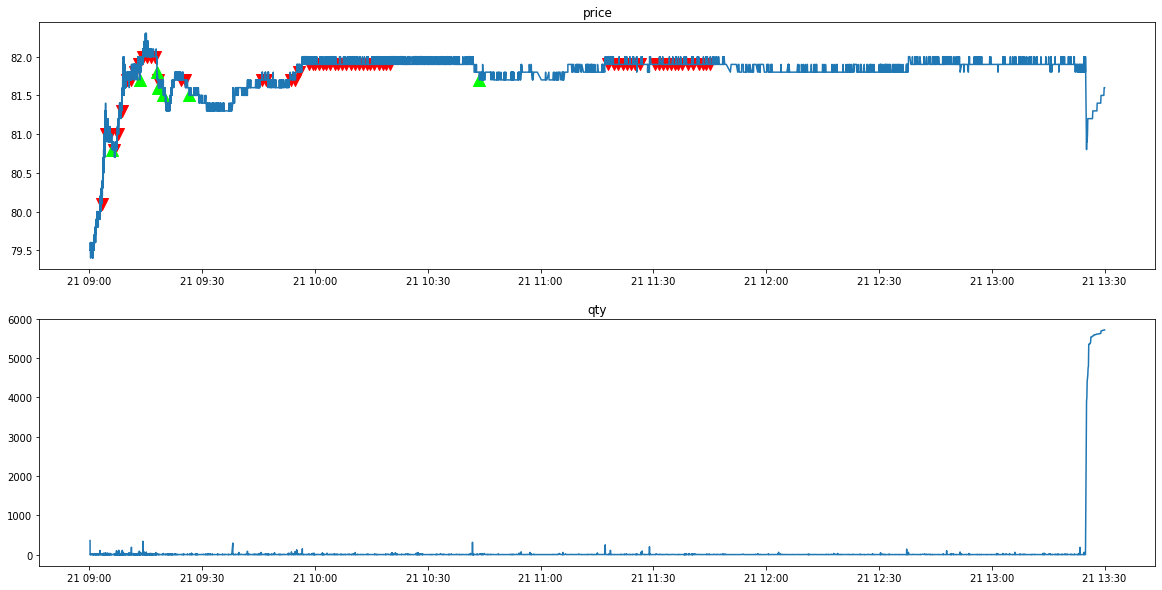

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90001766
*** bid1_p:  82.8
*** weighted_p:  82.51526627218936
ask1_p:  82.9
進場時間： 90356114 
  sell price at  82.8
stop profit
出場時間： 91239979
POSITION(pre):  [82.8]
Order_p(pre):  [82.6]
tick_row price:  82.6
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 83.0
----------Result Report--------------
profit:  0.20000000000000284


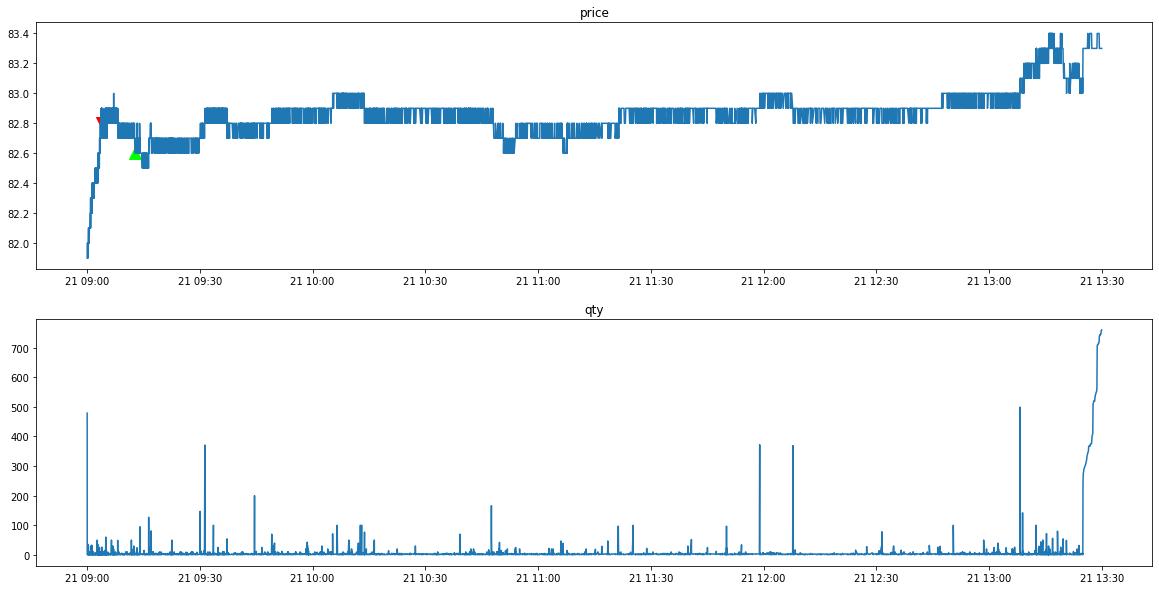

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90003619
*** bid1_p:  82.8
*** weighted_p:  82.55940594059405
ask1_p:  82.9
進場時間： 90600337 
  sell price at  82.8
stop profit
出場時間： 90601612
POSITION(pre):  [82.8]
Order_p(pre):  [82.6]
tick_row price:  82.6
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 81.3
----------Result Report--------------
profit:  0.20000000000000284


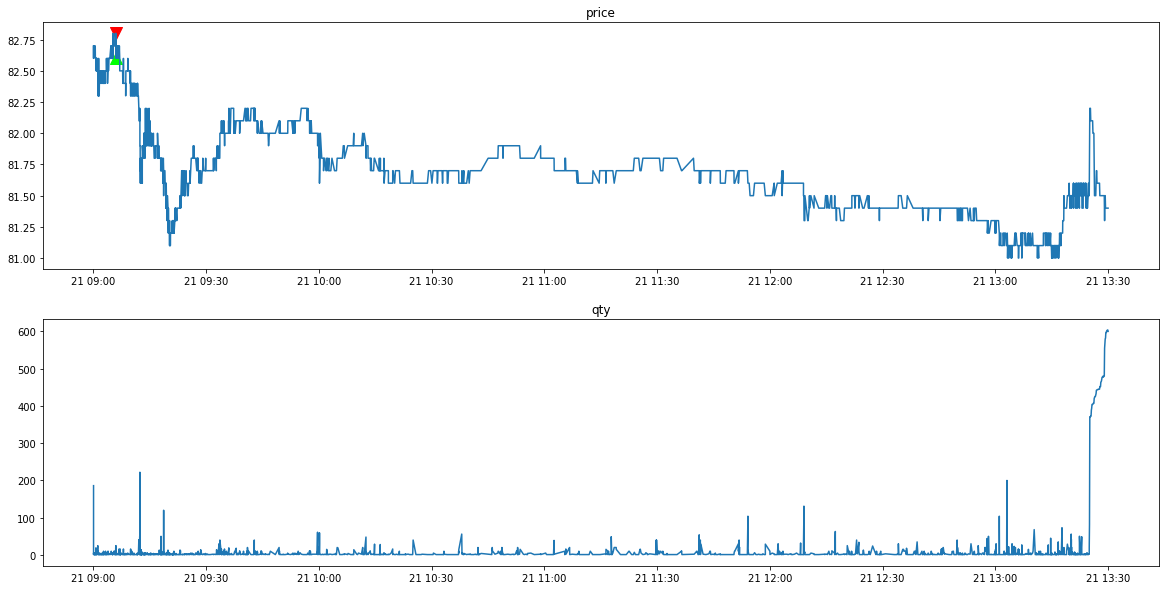

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90005586
clear_position:  0.0
position:  []
tick_row_price 80.3
----------Result Report--------------
profit:  0.0


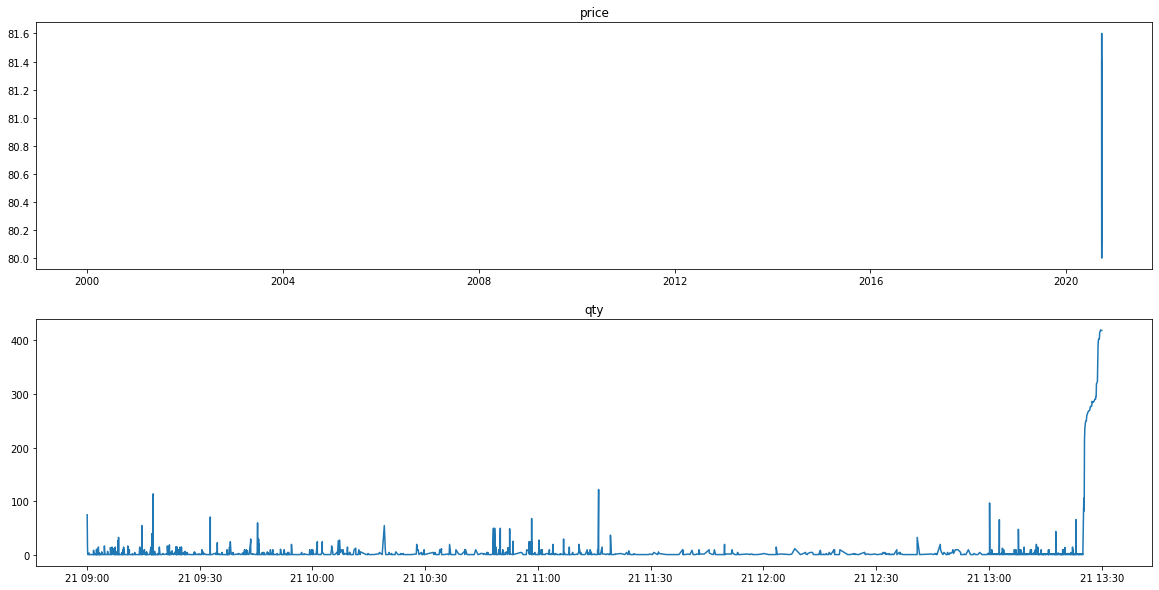

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90008320
*** bid1_p:  79.2
*** weighted_p:  78.8338180112571
ask1_p:  79.3
進場時間： 92902122 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.83955637707956
ask1_p:  79.3
進場時間： 93006962 
  sell price at  79.2
stop profit
出場時間： 93012045
POSITION(pre):  [79.2 79.2]
Order_p(pre):  [79. 79.]
tick_row price:  79.0
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 78.0
----------Result Report--------------
profit:  0.4000000000000057


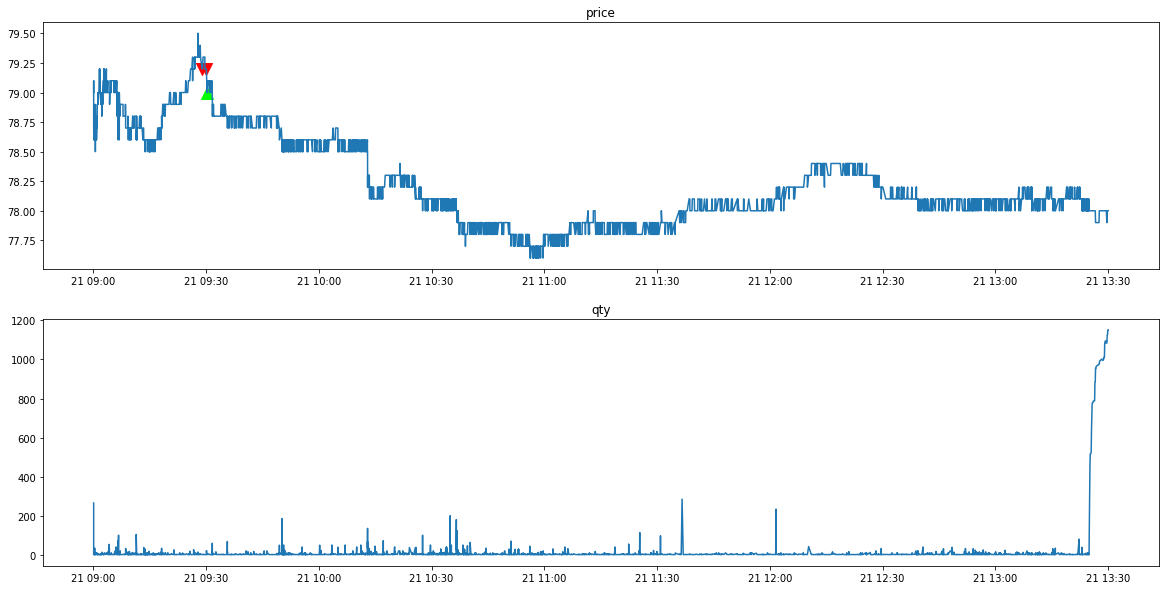

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90005328
*** bid1_p:  78.8
*** weighted_p:  78.5920377867747
ask1_p:  78.9
進場時間： 92421878 
  sell price at  78.8
*** bid1_p:  78.9
*** weighted_p:  78.64485875706221
ask1_p:  79.0
進場時間： 93018842 
  sell price at  78.9
*** bid1_p:  78.9
*** weighted_p:  78.66589716684159
ask1_p:  79.0
進場時間： 93308034 
  sell price at  78.9
stop profit
出場時間： 94313450
POSITION(pre):  [78.8 78.9 78.9]
Order_p(pre):  [78.6 78.7 78.7]
tick_row price:  78.7
qualified index:  [[1]
 [2]]
POSITION(post):  [78.8]
Order_p(post):  [78.6]

stop profit
出場時間： 94448245
POSITION(pre):  [78.8]
Order_p(pre):  [78.6]
tick_row price:  78.6
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  79.1
*** weighted_p:  78.71874455100301
ask1_p: 

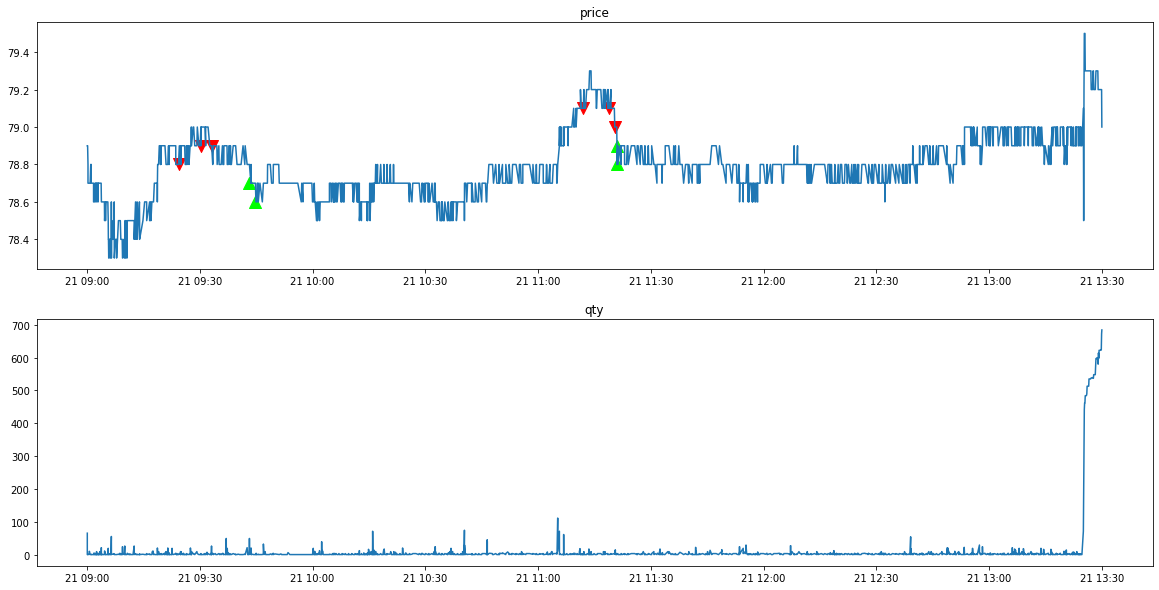

In [ ]:
res_1301 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), "1301")

In [ ]:
profit_1301, cost_1301 = calculate_profit(res_1301)

In [ ]:
profit_1301

4.100000000000051

In [ ]:
cost_1301

6746.7999999999965

#### 2002


<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90003631
*** bid1_p:  20.7
*** weighted_p:  20.633352442100392
ask1_p:  20.75
進場時間： 93921686 
  sell price at  20.7
*** bid1_p:  20.75
*** weighted_p:  20.66262686062241
ask1_p:  20.8
進場時間： 100452134 
  sell price at  20.75
*** bid1_p:  20.75
*** weighted_p:  20.67003713445761
ask1_p:  20.8
進場時間： 101753845 
  sell price at  20.75
*** bid1_p:  20.75
*** weighted_p:  20.67130547506474
ask1_p:  20.8
進場時間： 101903140 
  sell price at  20.75
*** bid1_p:  20.75
*** weighted_p:  20.672361467612777
ask1_p:  20.8
進場時間： 102100725 
  sell price at  20.75
*** bid1_p:  20.85
*** weighted_p:  20.70107238605892
ask1_p:  20.9
進場時間： 104039048 
  sell price at  20.85
*** bid1_p:  20.85
*** weighted_p:  20.70429785705729
ask1_p:  20.9
進場時間： 10

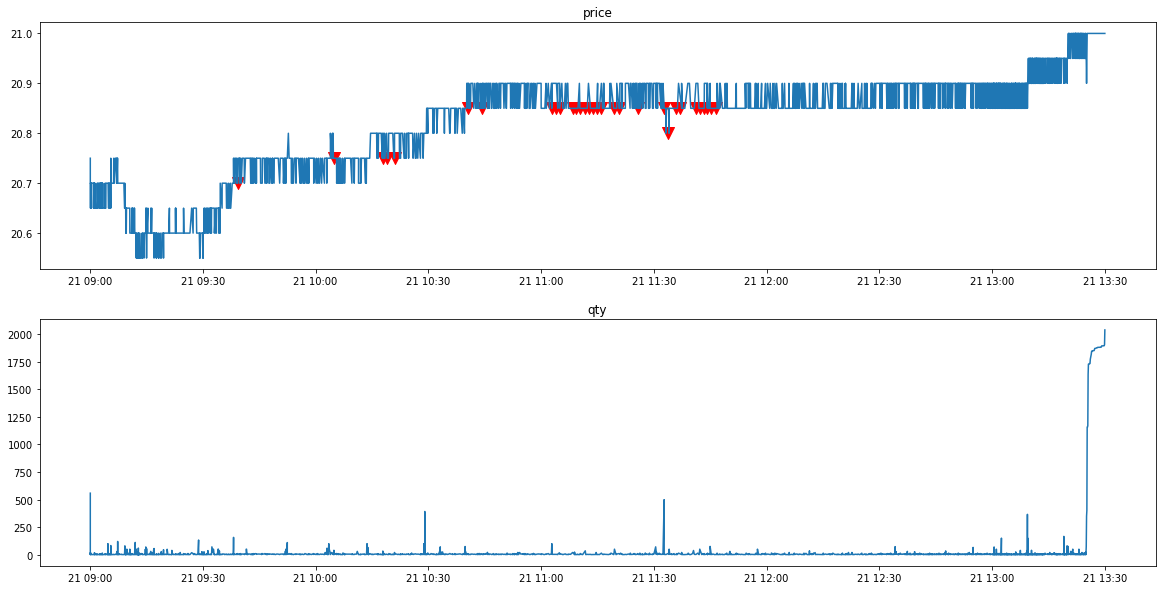

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005464
*** bid1_p:  20.9
*** weighted_p:  20.804523842819226
ask1_p:  20.95
進場時間： 104542236 
  sell price at  20.9
stop profit
出場時間： 105741098
POSITION(pre):  [20.9]
Order_p(pre):  [20.8]
tick_row price:  20.8
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.09999999999999787


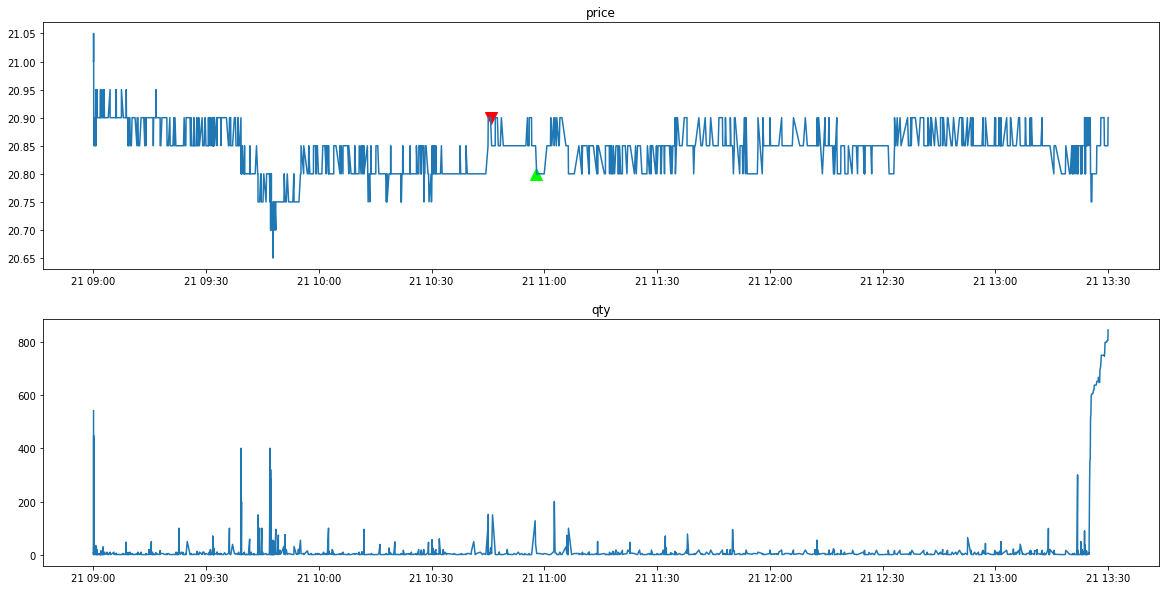

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90007198
clear_position:  0.0
position:  []
tick_row_price 20.85
----------Result Report--------------
profit:  0.0


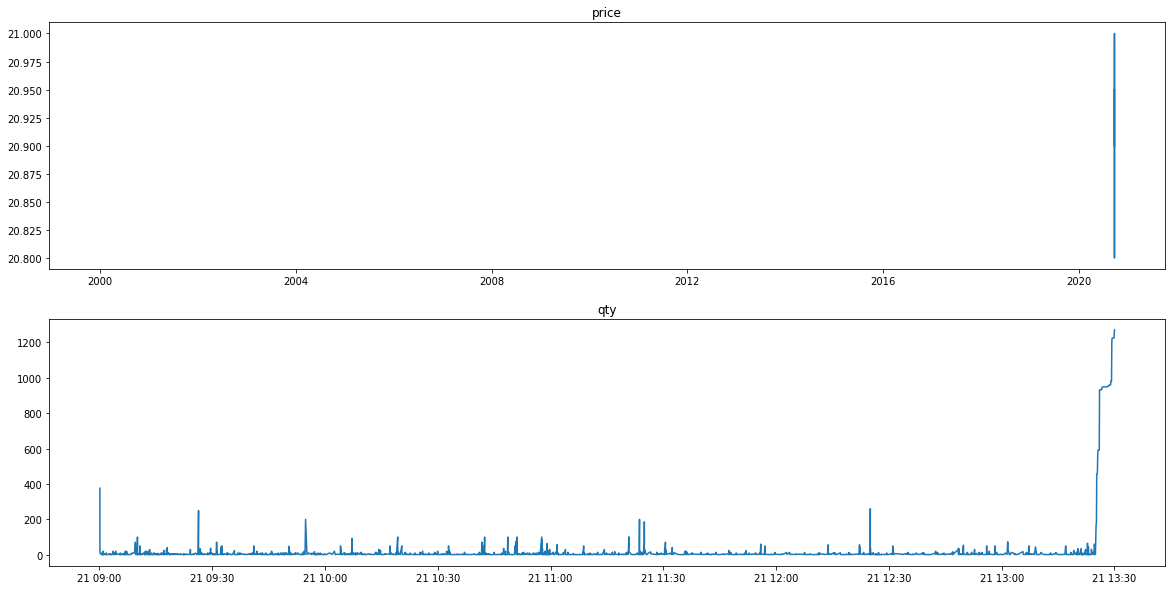

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005711
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


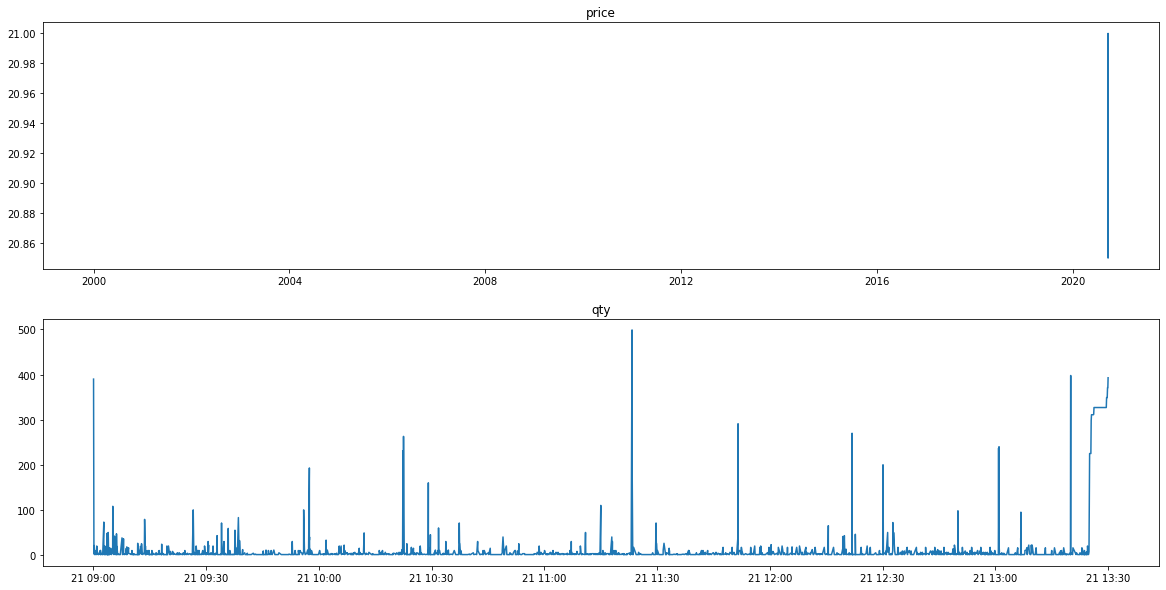

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005269
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


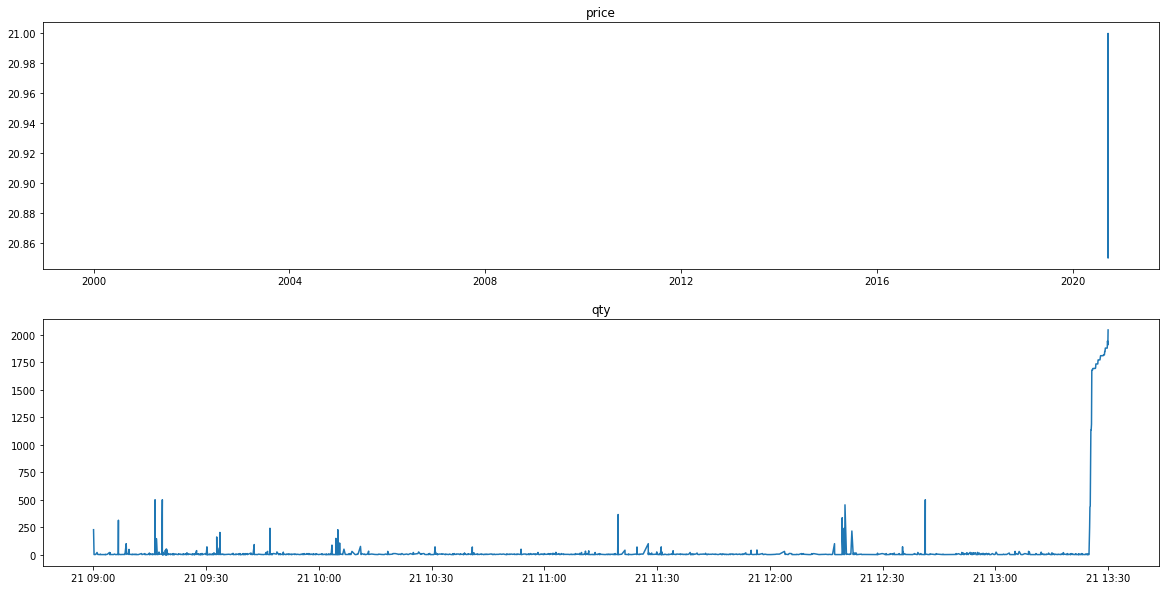

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005515
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


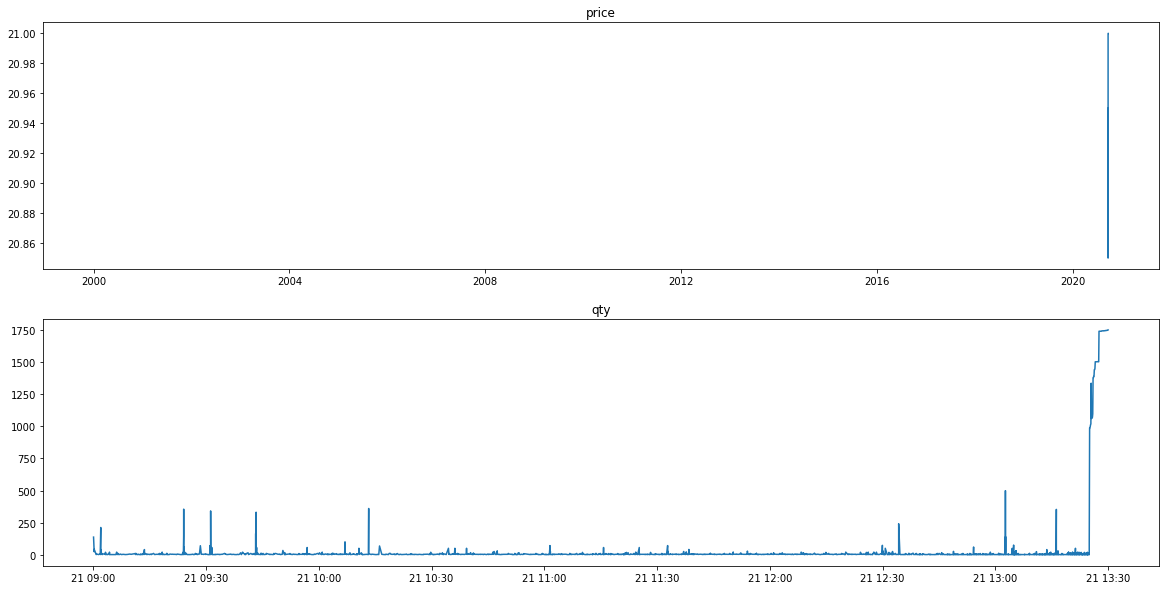

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90006154
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


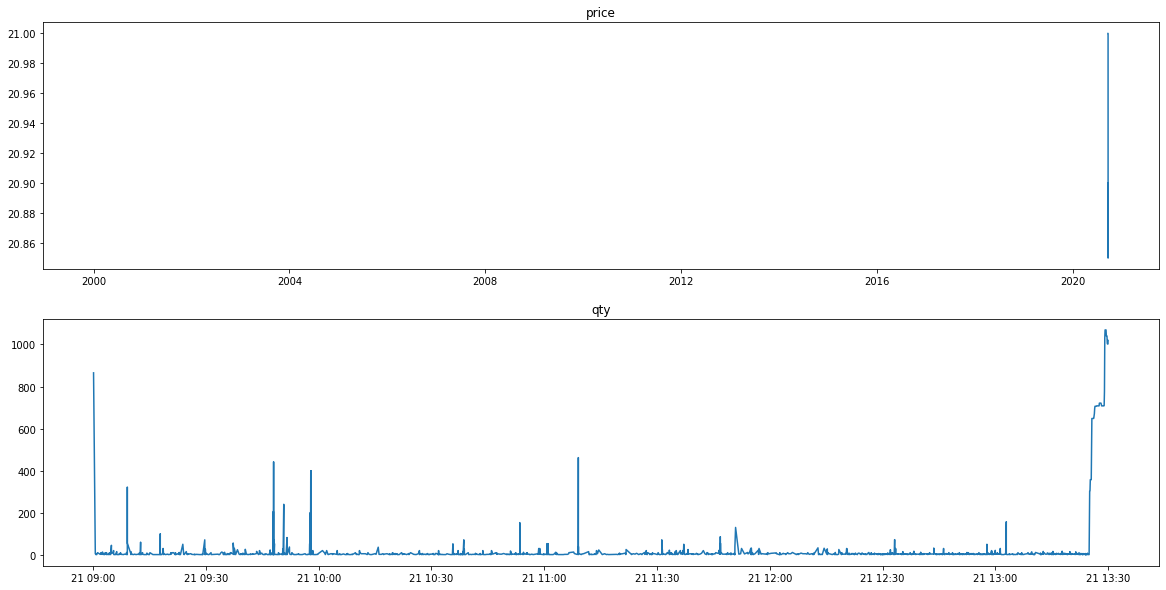

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90007479
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


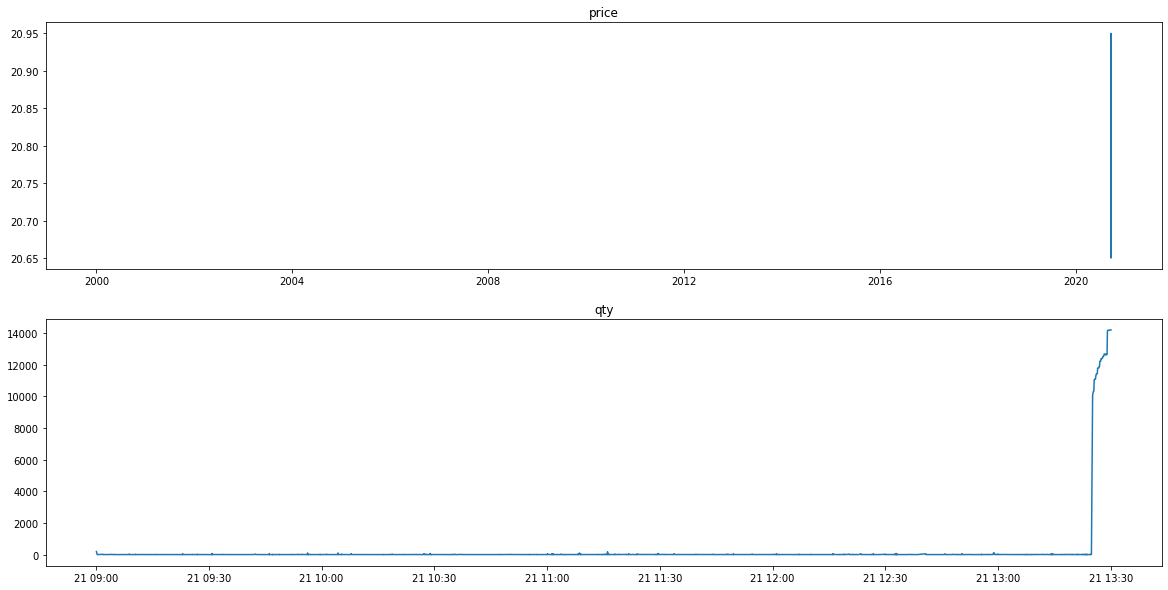

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90006780
clear_position:  0.0
position:  []
tick_row_price 20.75
----------Result Report--------------
profit:  0.0


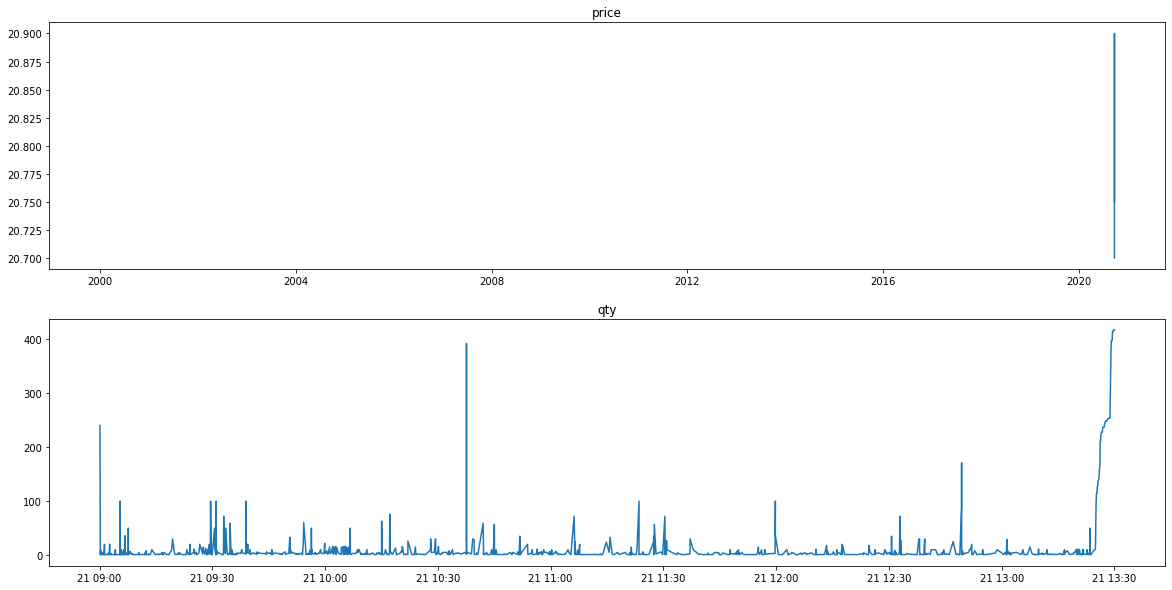

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90008840
clear_position:  0.0
position:  []
tick_row_price 20.7
----------Result Report--------------
profit:  0.0


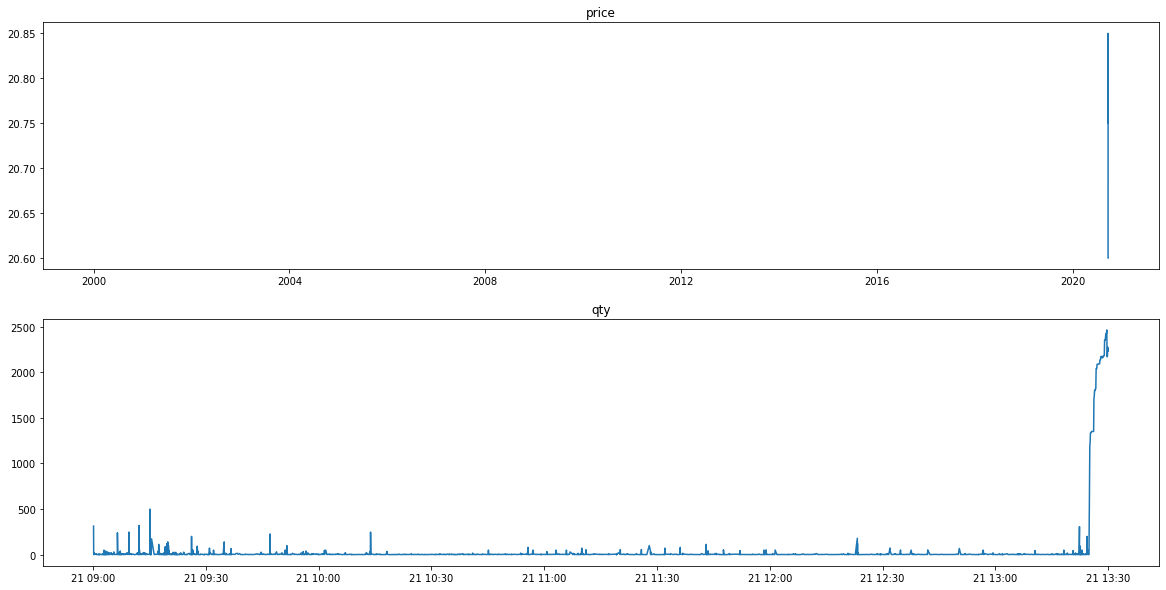

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90006388
clear_position:  0.0
position:  []
tick_row_price 20.5
----------Result Report--------------
profit:  0.0


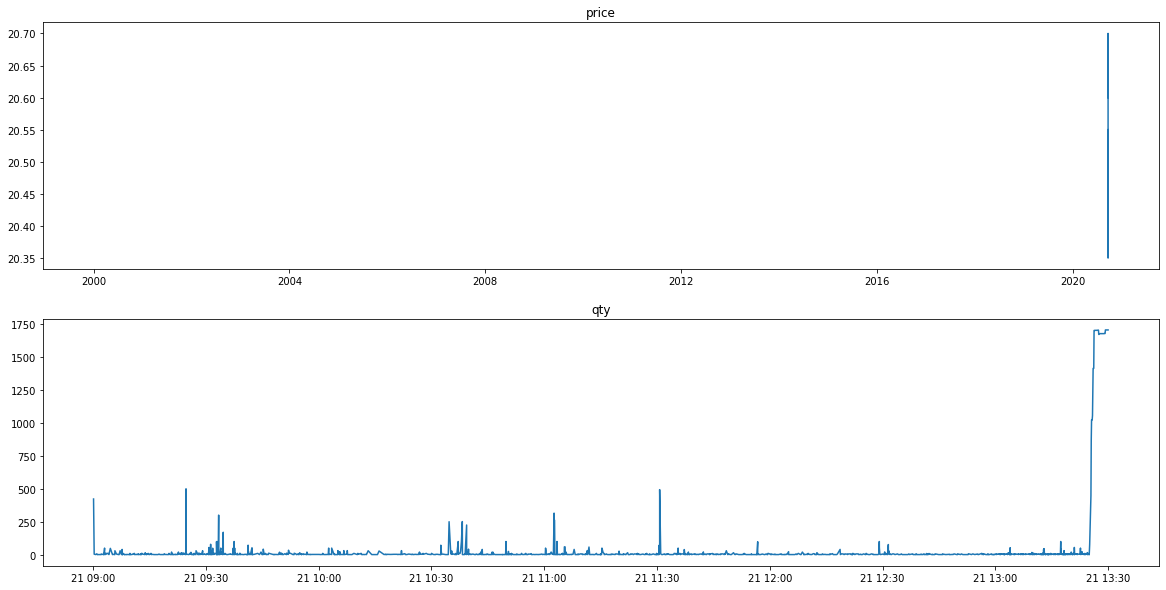

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90007316
clear_position:  0.0
position:  []
tick_row_price 20.05
----------Result Report--------------
profit:  0.0


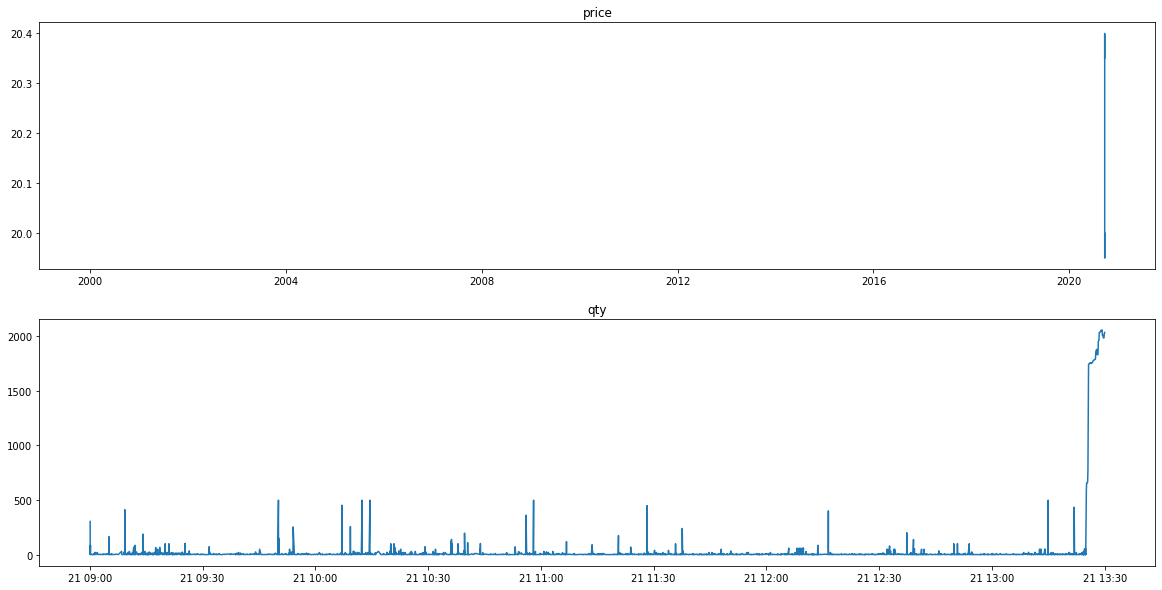

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005859
clear_position:  0.0
position:  []
tick_row_price 20.15
----------Result Report--------------
profit:  0.0


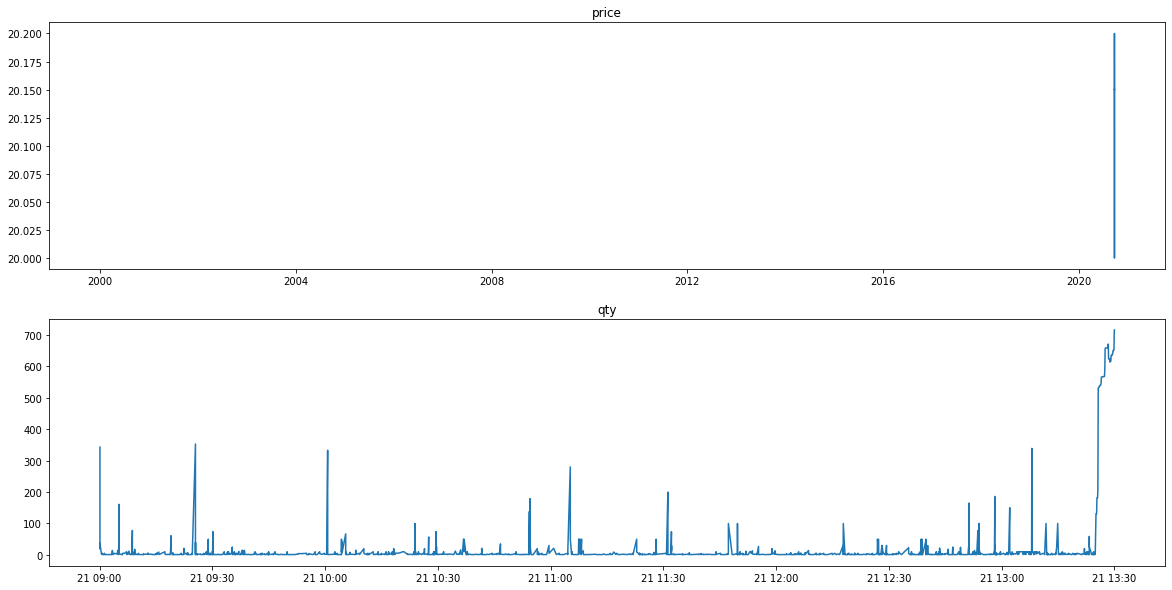

In [ ]:
para = {"sid": "2002", "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": 100000, "stop_loss_factor": 1.02, "theta": 1.0025, "position_max_q": 10}
res_2002 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
profit_2002, cost_2002 = calculate_profit(res_2002)

In [ ]:
profit_2002

-0.5000000000000107

In [ ]:
cost_2002

666.6500000000003

#### 2454


<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90004434
*** bid1_p:  598.0
*** weighted_p:  596.2631578947369
ask1_p:  599.0
進場時間： 90332777 
  sell price at  598.0
stop profit
出場時間： 90549884
POSITION(pre):  [598.]
Order_p(pre):  [596.]
tick_row price:  596.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  593.0
*** weighted_p:  591.5151767151767
ask1_p:  594.0
進場時間： 122200153 
  sell price at  593.0
*** bid1_p:  594.0
*** weighted_p:  591.6122903563942
ask1_p:  595.0
進場時間： 124117156 
  sell price at  594.0
*** bid1_p:  594.0
*** weighted_p:  591.623842441633
ask1_p:  595.0
進場時間： 124217861 
  sell price at  594.0
*** bid1_p:  594.0
*** weighted_p:  591.6269706840391
ask1_p:  595.0
進場時間： 124321755 
  sell price at  594.0
*** bid1_p:  594.0
***

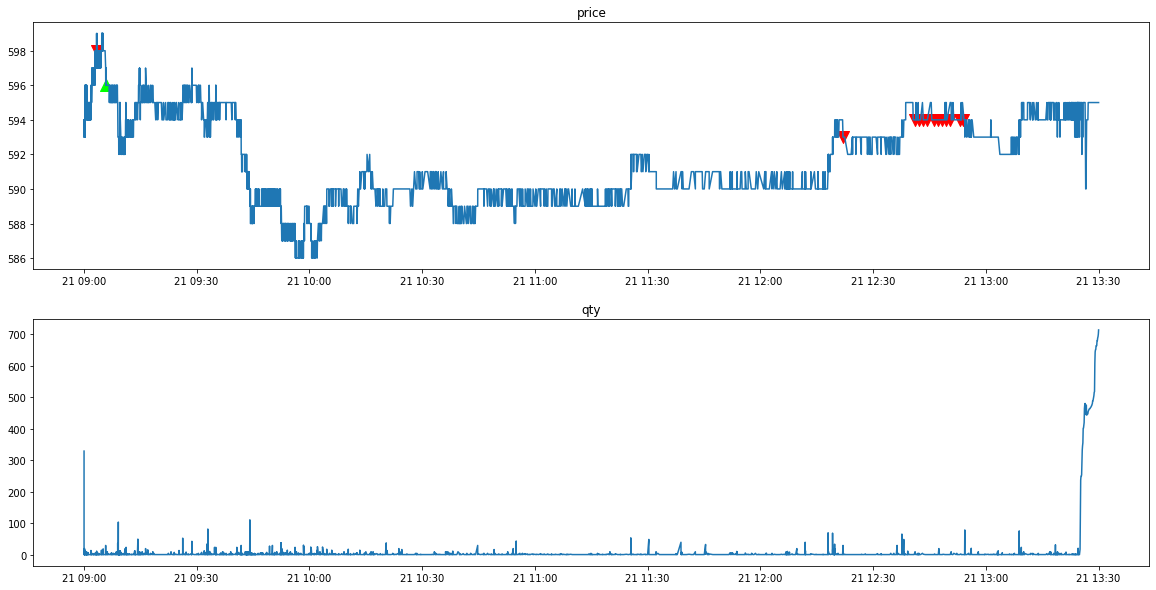

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003858
*** bid1_p:  606.0
*** weighted_p:  604.2091254752852
ask1_p:  607.0
進場時間： 90504416 
  sell price at  606.0
stop profit
出場時間： 90655041
POSITION(pre):  [606.]
Order_p(pre):  [604.]
tick_row price:  604.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 599.0
----------Result Report--------------
profit:  2.0


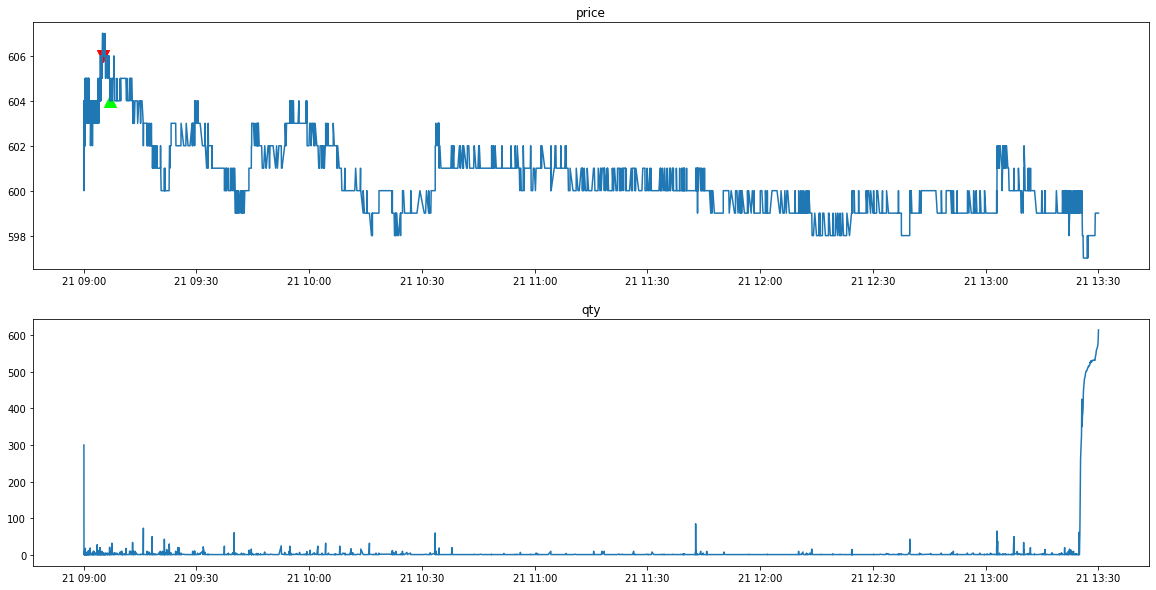

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90004186
*** bid1_p:  595.0
*** weighted_p:  592.8907520325204
ask1_p:  596.0
進場時間： 102435994 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  592.9686351384464
ask1_p:  596.0
進場時間： 103337599 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  592.9810034096445
ask1_p:  596.0
進場時間： 103437808 
  sell price at  595.0
stop profit
出場時間： 104514494
POSITION(pre):  [595. 595. 595.]
Order_p(pre):  [593. 593. 593.]
tick_row price:  593.0
qualified index:  [[0]
 [1]
 [2]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 593.0
----------Result Report--------------
profit:  6.0


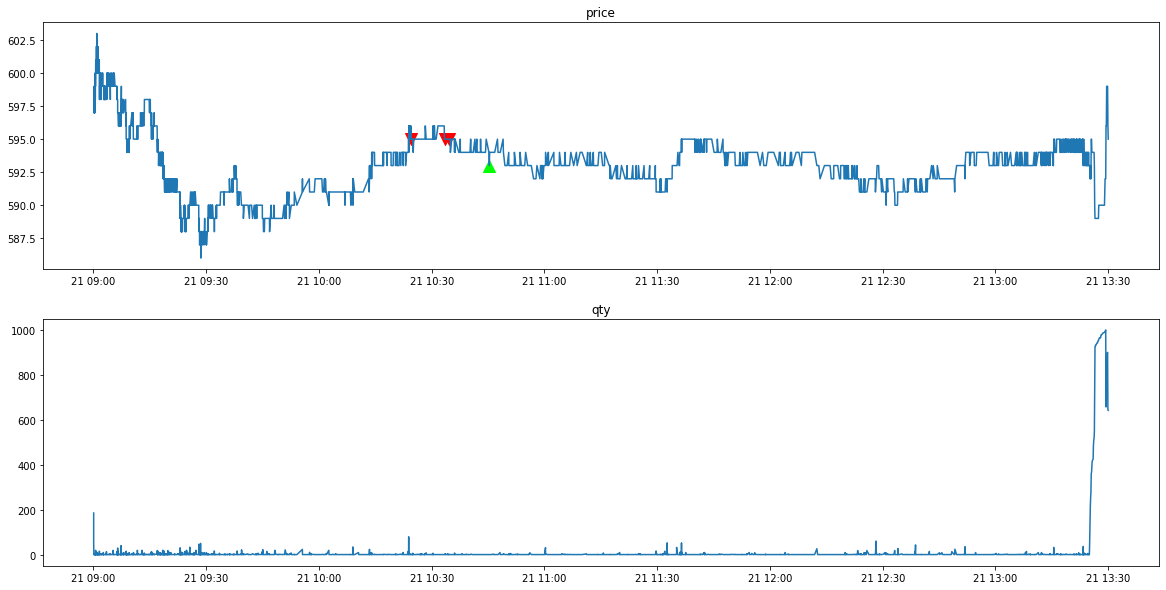

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003530
*** bid1_p:  594.0
*** weighted_p:  592.2886710239651
ask1_p:  595.0
進場時間： 91050314 
  sell price at  594.0
*** bid1_p:  596.0
*** weighted_p:  592.9250411861615
ask1_p:  597.0
進場時間： 91258249 
  sell price at  596.0
*** bid1_p:  595.0
*** weighted_p:  593.0460683081811
ask1_p:  596.0
進場時間： 91358396 
  sell price at  595.0
*** bid1_p:  598.0
*** weighted_p:  593.4238267148014
ask1_p:  599.0
進場時間： 91620885 
  sell price at  598.0
*** bid1_p:  598.0
*** weighted_p:  593.963589076723
ask1_p:  599.0
進場時間： 91859053 
  sell price at  598.0
stop profit
出場時間： 91953938
POSITION(pre):  [594. 596. 595. 598. 598.]
Order_p(pre):  [592. 594. 593. 596. 596.]
tick_row price:  596.0
qualified index:  [[3]
 [4]]
POSITION(post):  [594

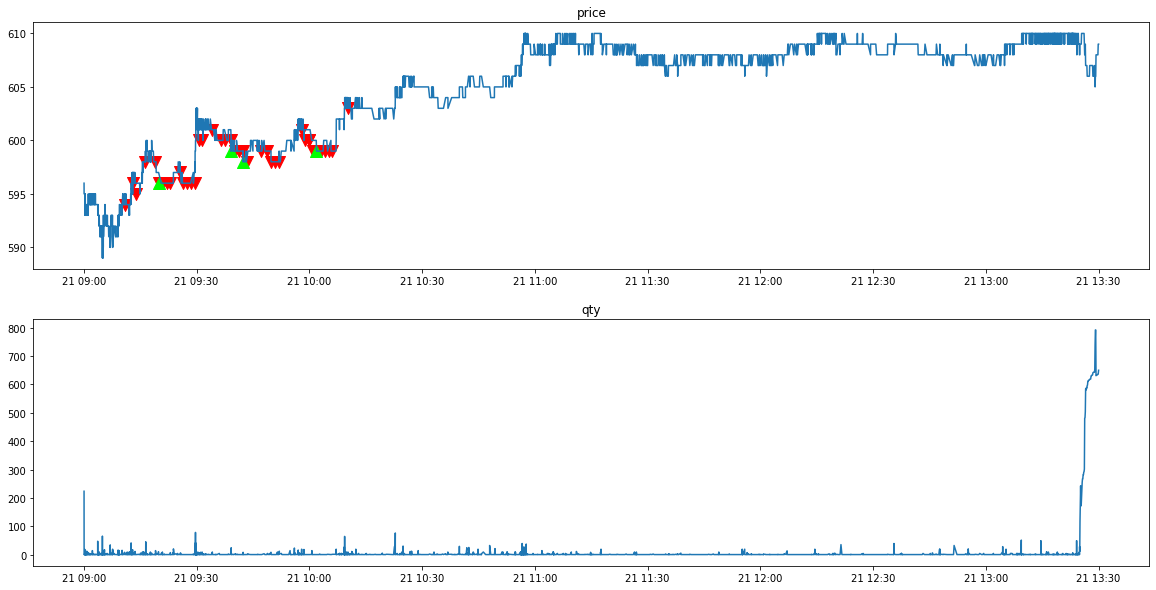

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003263
*** bid1_p:  611.0
*** weighted_p:  607.5784392598551
ask1_p:  612.0
進場時間： 91915149 
  sell price at  611.0
*** bid1_p:  610.0
*** weighted_p:  607.6824167312161
ask1_p:  611.0
進場時間： 92015738 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  607.8293943870015
ask1_p:  611.0
進場時間： 92117029 
  sell price at  610.0
stop profit
出場時間： 92123814
POSITION(pre):  [611. 610. 610.]
Order_p(pre):  [609. 608. 608.]
tick_row price:  609.0
qualified index:  [[0]]
POSITION(post):  [610. 610.]
Order_p(post):  [608. 608.]

*** bid1_p:  610.0
*** weighted_p:  608.0663164806303
ask1_p:  611.0
進場時間： 92717863 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.1513819095477
ask1_p:  611.0
進場時間： 92934504 
  sell pri

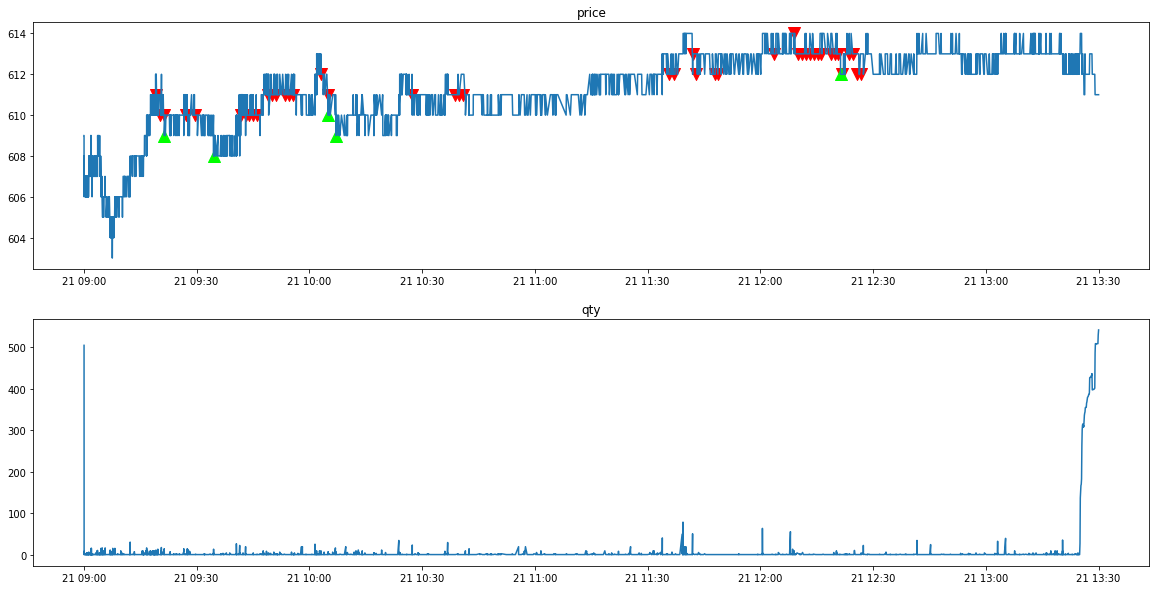

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002919
*** bid1_p:  621.0
*** weighted_p:  618.4882459312839
ask1_p:  622.0
進場時間： 90720176 
  sell price at  621.0
*** bid1_p:  621.0
*** weighted_p:  618.9653614457832
ask1_p:  622.0
進場時間： 90820189 
  sell price at  621.0
stop profit
出場時間： 90943729
POSITION(pre):  [621. 621.]
Order_p(pre):  [619. 619.]
tick_row price:  619.0
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  621.0
*** weighted_p:  619.2239119035133
ask1_p:  622.0
進場時間： 91920383 
  sell price at  621.0
*** bid1_p:  621.0
*** weighted_p:  619.3200795228628
ask1_p:  622.0
進場時間： 92107868 
  sell price at  621.0
stop profit
出場時間： 92745543
POSITION(pre):  [621. 621.]
Order_p(pre):  [619. 619.]
tick_row price:  619.0
qualified ind

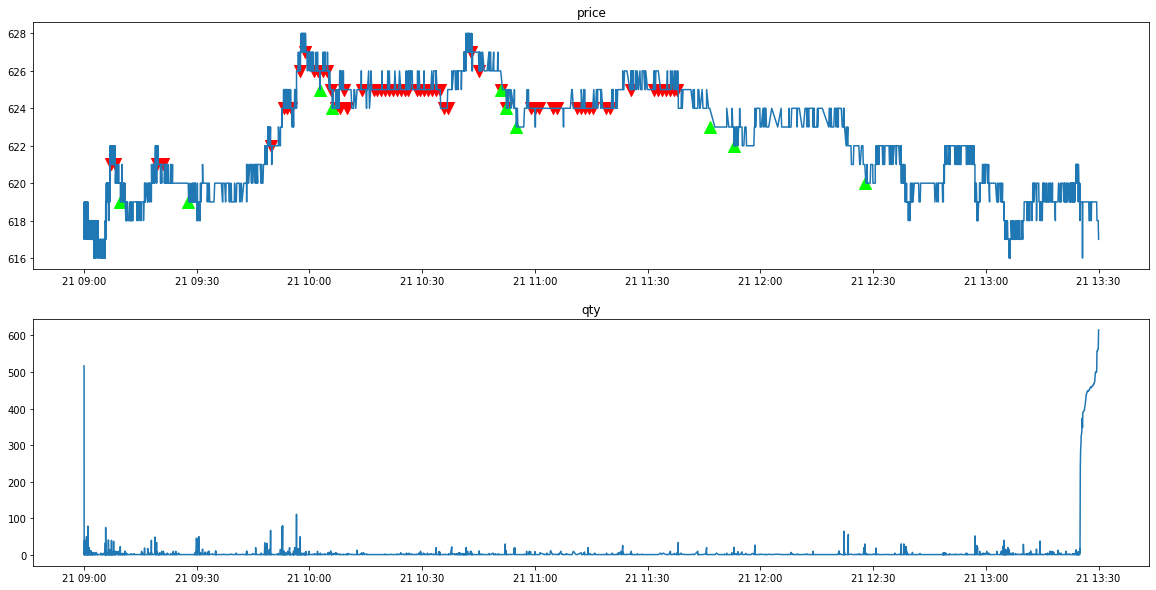

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002544
*** bid1_p:  605.0
*** weighted_p:  603.1549604916594
ask1_p:  606.0
進場時間： 91531464 
  sell price at  605.0
stop profit
出場時間： 91700419
POSITION(pre):  [605.]
Order_p(pre):  [603.]
tick_row price:  603.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 596.0
----------Result Report--------------
profit:  2.0


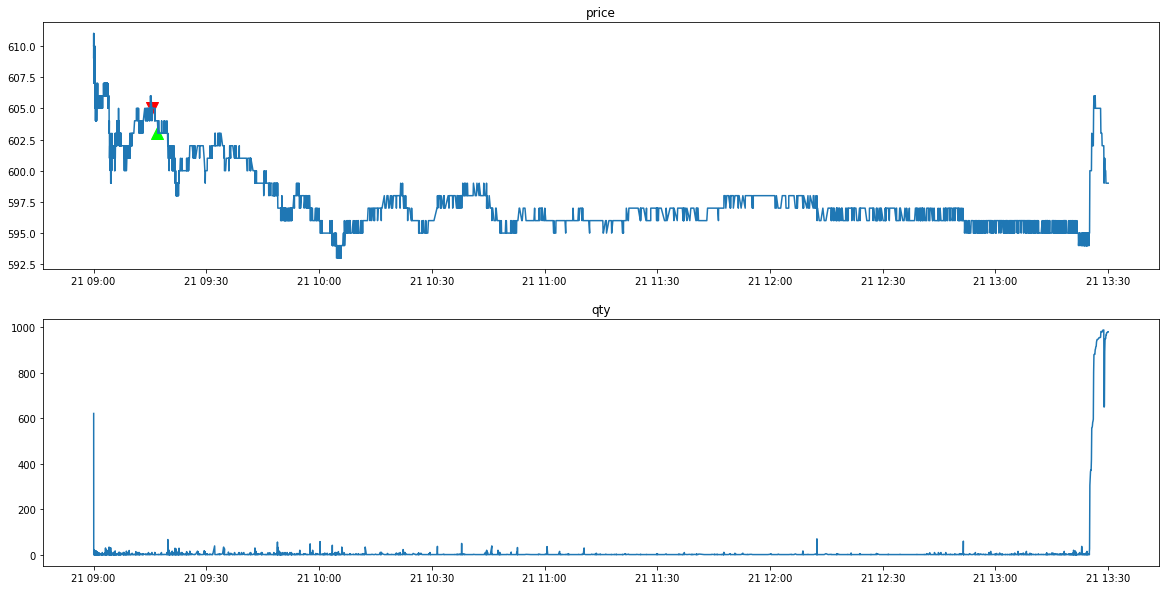

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002257
*** bid1_p:  599.0
*** weighted_p:  595.182320441989
ask1_p:  600.0
進場時間： 101700140 
  sell price at  599.0
*** bid1_p:  602.0
*** weighted_p:  595.5439101641232
ask1_p:  603.0
進場時間： 101930084 
  sell price at  602.0
*** bid1_p:  601.0
*** weighted_p:  595.7357541899441
ask1_p:  602.0
進場時間： 102155798 
  sell price at  601.0
stop profit
出場時間： 102253885
POSITION(pre):  [599. 602. 601.]
Order_p(pre):  [597. 600. 599.]
tick_row price:  600.0
qualified index:  [[1]]
POSITION(post):  [599. 601.]
Order_p(post):  [597. 599.]

*** bid1_p:  600.0
*** weighted_p:  595.7884402654868
ask1_p:  602.0
進場時間： 102259501 
  sell price at  600.0
*** bid1_p:  601.0
*** weighted_p:  595.873231773667
ask1_p:  602.0
進場時間： 102642285 
  sell

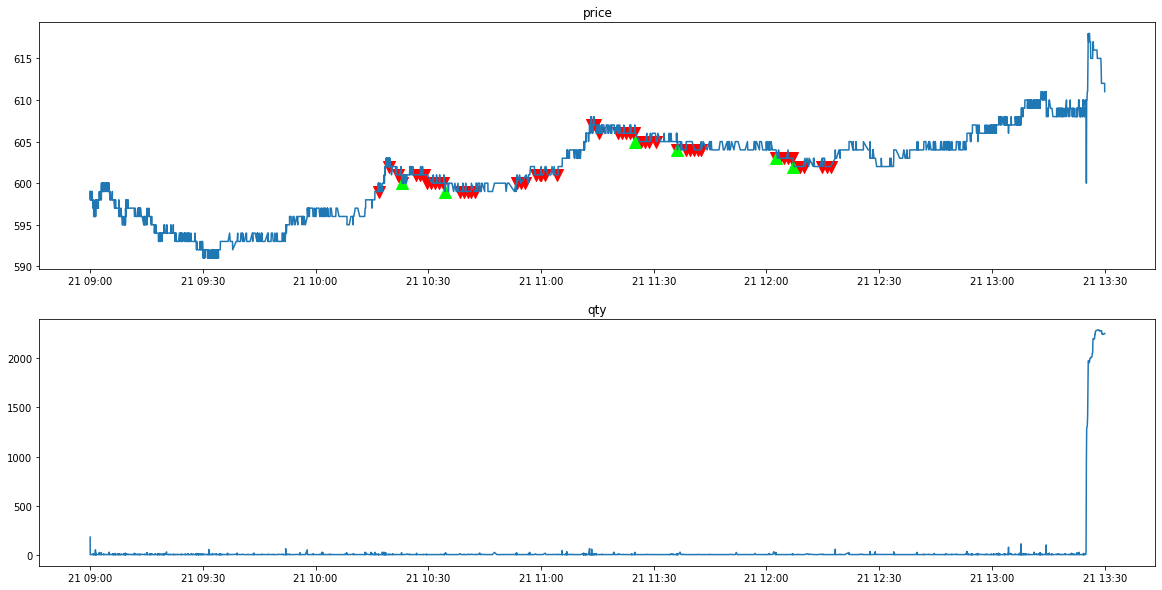

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002456
*** bid1_p:  617.0
*** weighted_p:  615.3340314136126
ask1_p:  618.0
進場時間： 90726158 
  sell price at  617.0
*** bid1_p:  618.0
*** weighted_p:  615.6383561643836
ask1_p:  619.0
進場時間： 90854907 
  sell price at  618.0
*** bid1_p:  619.0
*** weighted_p:  616.2939460247994
ask1_p:  620.0
進場時間： 91122818 
  sell price at  619.0
*** bid1_p:  619.0
*** weighted_p:  616.4044943820224
ask1_p:  620.0
進場時間： 91223002 
  sell price at  619.0
stop profit
出場時間： 91236230
POSITION(pre):  [617. 618. 619. 619.]
Order_p(pre):  [615. 616. 617. 617.]
tick_row price:  617.0
qualified index:  [[2]
 [3]]
POSITION(post):  [617. 618.]
Order_p(post):  [615. 616.]

*** bid1_p:  621.0
*** weighted_p:  617.2084355076017
ask1_p:  622.0
進場時間： 91557

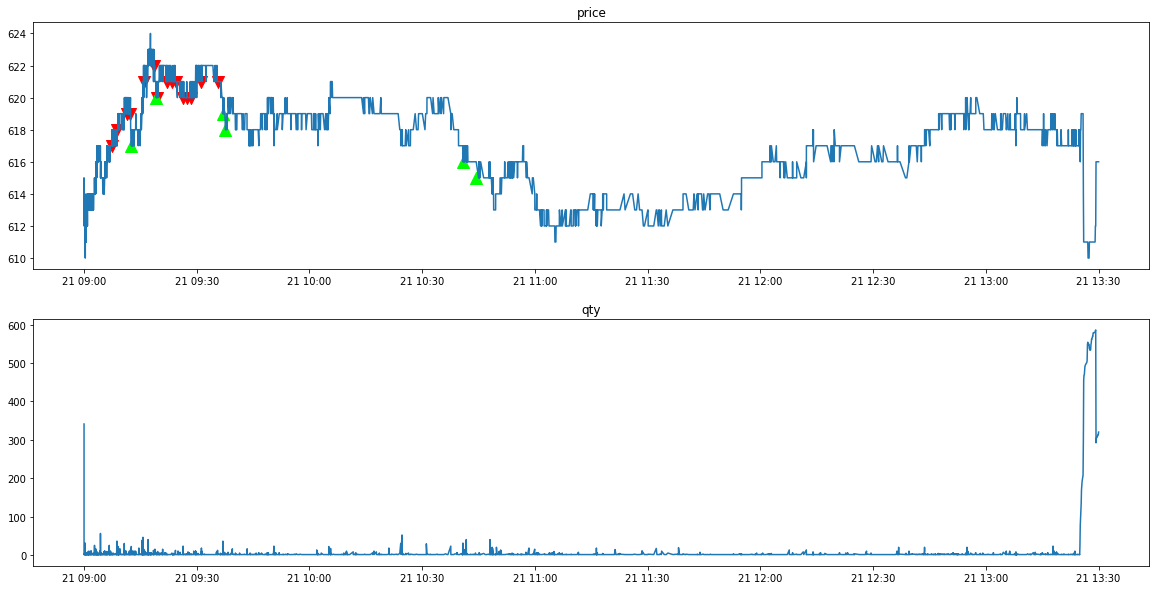

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002610
*** bid1_p:  611.0
*** weighted_p:  608.3541979010495
ask1_p:  612.0
進場時間： 95433700 
  sell price at  611.0
*** bid1_p:  611.0
*** weighted_p:  608.4080206033849
ask1_p:  612.0
進場時間： 95722509 
  sell price at  611.0
*** bid1_p:  610.0
*** weighted_p:  608.4323144104803
ask1_p:  611.0
進場時間： 95823127 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.435524881947
ask1_p:  611.0
進場時間： 95925743 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.435524881947
ask1_p:  611.0
進場時間： 100001095 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.4383164005806
ask1_p:  611.0
進場時間： 100104267 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.4388828436706
ask1_p:  611.0
進場時間： 1

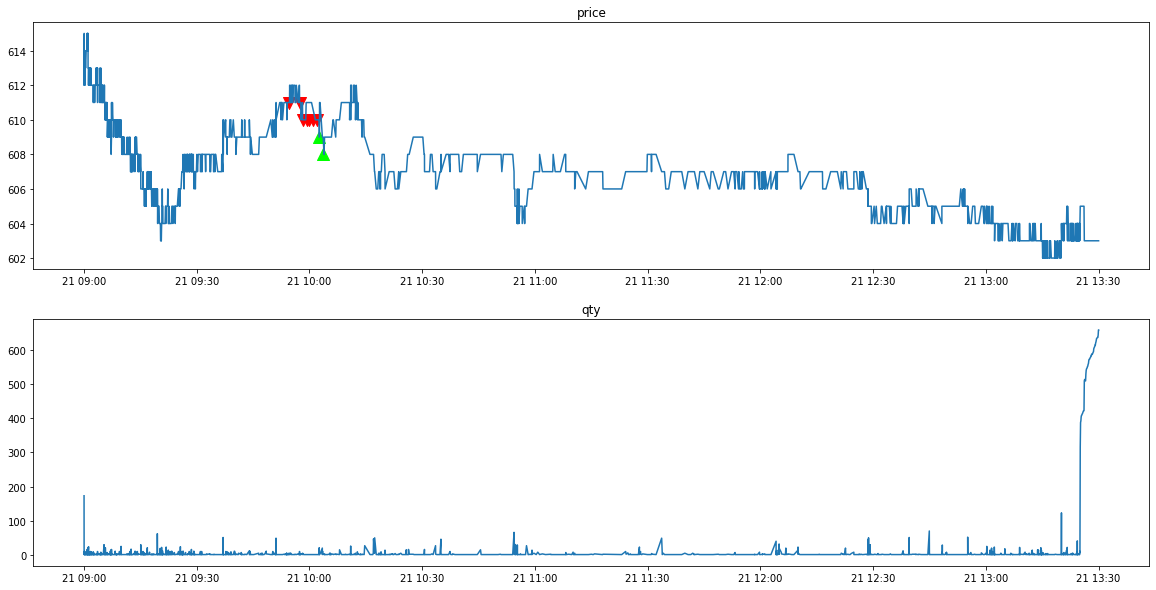

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003781
*** bid1_p:  616.0
*** weighted_p:  614.1991294885745
ask1_p:  617.0
進場時間： 105914184 
  sell price at  616.0
*** bid1_p:  616.0
*** weighted_p:  614.2028237849579
ask1_p:  617.0
進場時間： 110000076 
  sell price at  616.0
stop profit
出場時間： 110121612
POSITION(pre):  [616. 616.]
Order_p(pre):  [614. 614.]
tick_row price:  614.0
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  617.0
*** weighted_p:  614.4389823199655
ask1_p:  618.0
進場時間： 121204001 
  sell price at  617.0
*** bid1_p:  617.0
*** weighted_p:  614.4806465333901
ask1_p:  618.0
進場時間： 121742392 
  sell price at  617.0
*** bid1_p:  617.0
*** weighted_p:  614.5975388339722
ask1_p:  618.0
進場時間： 124141185 
  sell price at  617.0
*** 

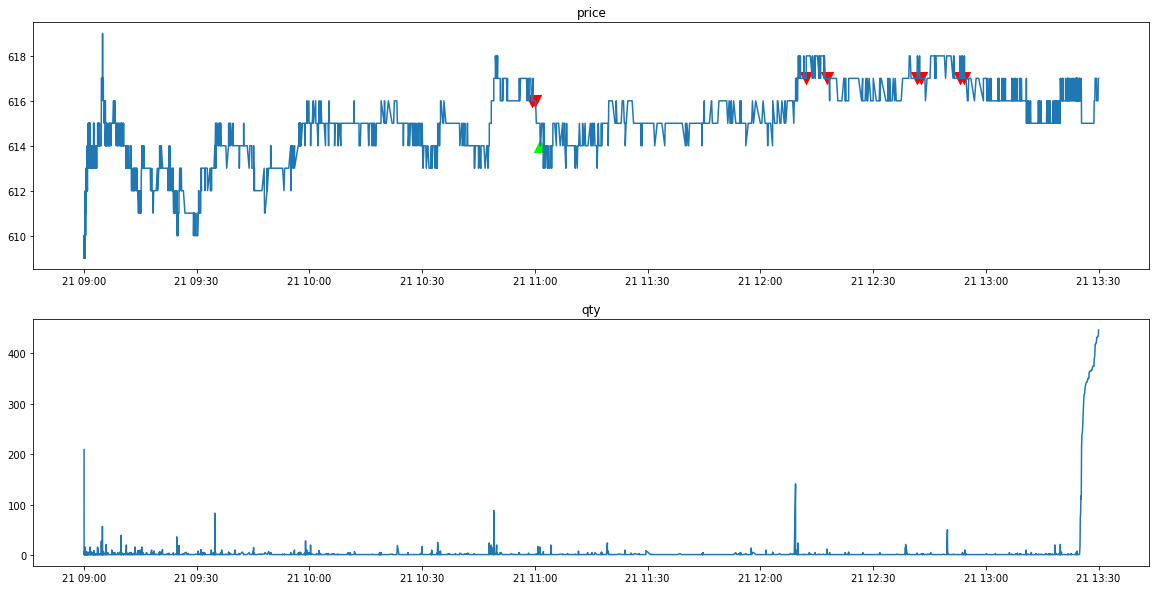

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003676
*** bid1_p:  611.0
*** weighted_p:  609.4311594202899
ask1_p:  612.0
進場時間： 90229679 
  sell price at  611.0
*** bid1_p:  613.0
*** weighted_p:  610.9291187739464
ask1_p:  614.0
進場時間： 90525413 
  sell price at  613.0
*** bid1_p:  613.0
*** weighted_p:  611.3136645962733
ask1_p:  614.0
進場時間： 90628758 
  sell price at  613.0
stop profit
出場時間： 90650313
POSITION(pre):  [611. 613. 613.]
Order_p(pre):  [608. 611. 611.]
tick_row price:  611.0
qualified index:  [[1]
 [2]]
POSITION(post):  [611.]
Order_p(post):  [608.]

stop profit
出場時間： 91446210
POSITION(pre):  [611.]
Order_p(pre):  [608.]
tick_row price:  608.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  614.0
*** weighted_p:  611.039455782

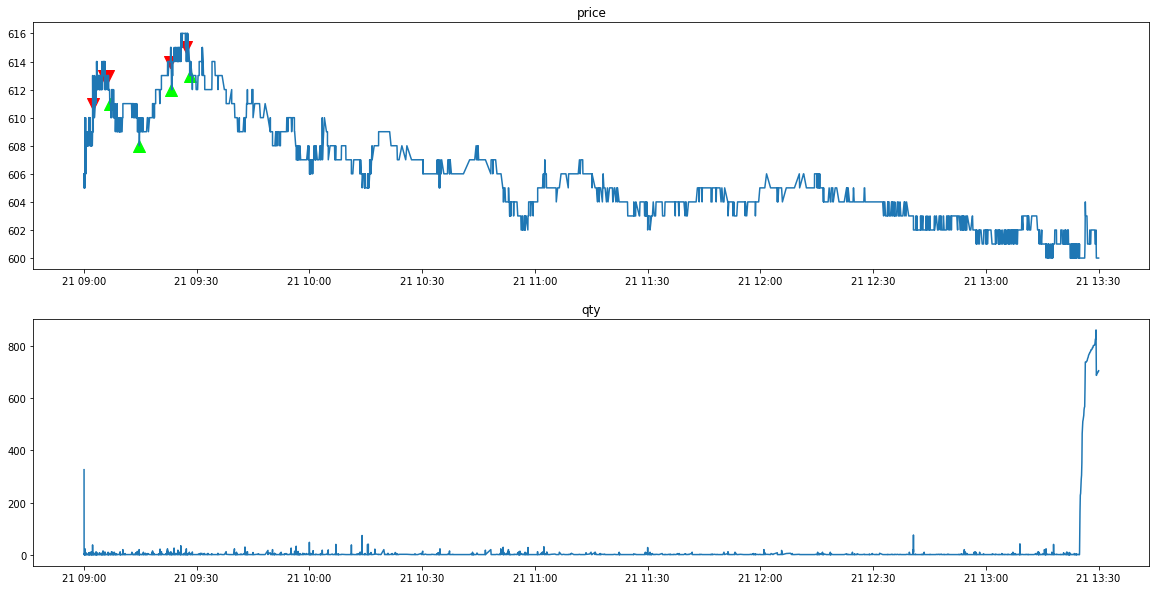

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90004455
clear_position:  0.0
position:  []
tick_row_price 588.0
----------Result Report--------------
profit:  0.0


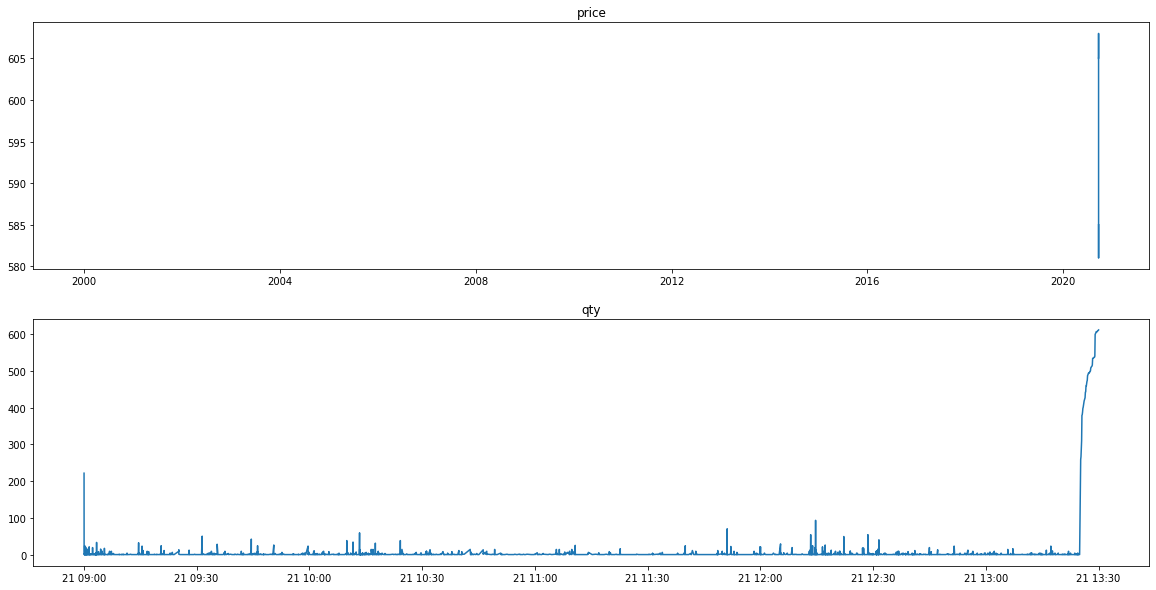

In [ ]:
para = {"sid": "2454", "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": 100000, "stop_loss_factor": 1.02, "theta": 1.0025, "position_max_q": 10}

res_2454 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
profit_2454, cost_2454 = calculate_profit(res_2454)

In [ ]:
profit_2454

-170.0

In [ ]:
cost_2454

156852.0

#### 2317



<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002287
*** bid1_p:  77.1
*** weighted_p:  76.90604458416729
ask1_p:  77.2
進場時間： 94118914 
  sell price at  77.1
stop profit
出場時間： 94653751
POSITION(pre):  [77.1]
Order_p(pre):  [76.9]
tick_row price:  76.9
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  77.6
*** weighted_p:  76.97970674879515
ask1_p:  77.7
進場時間： 124732062 
  sell price at  77.6
*** bid1_p:  77.7
*** weighted_p:  76.9977029496215
ask1_p:  77.8
進場時間： 124943979 
  sell price at  77.7
*** bid1_p:  77.6
*** weighted_p:  77.00556810116775
ask1_p:  77.7
進場時間： 125138494 
  sell price at  77.6
*** bid1_p:  77.6
*** weighted_p:  77.0125988772645
ask1_p:  77.7
進場時間： 125331570 
  sell price at  77.6
stop profit
出場時間： 125345632
POSITION(pr

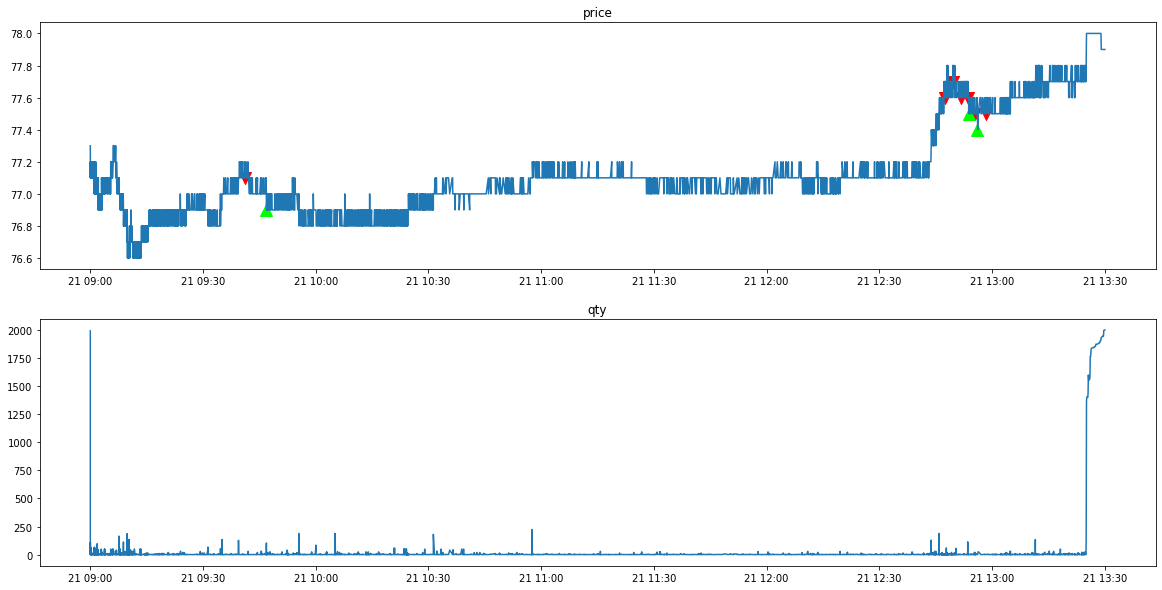

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002496
*** bid1_p:  78.6
*** weighted_p:  78.3792045141758
ask1_p:  78.7
進場時間： 91504006 
  sell price at  78.6
*** bid1_p:  78.6
*** weighted_p:  78.38727151434291
ask1_p:  78.7
進場時間： 91604119 
  sell price at  78.6
stop profit
出場時間： 91755639
POSITION(pre):  [78.6 78.6]
Order_p(pre):  [78.4 78.4]
tick_row price:  78.4
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 78.2
----------Result Report--------------
profit:  0.39999999999997726


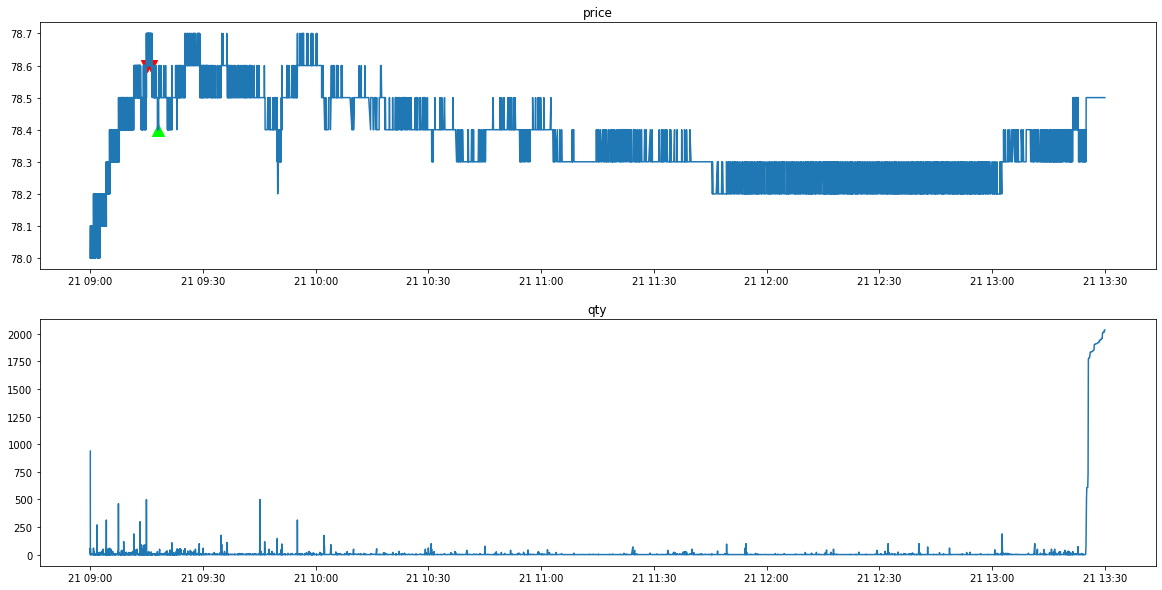

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002380
clear_position:  0.0
position:  []
tick_row_price 78.3
----------Result Report--------------
profit:  0.0


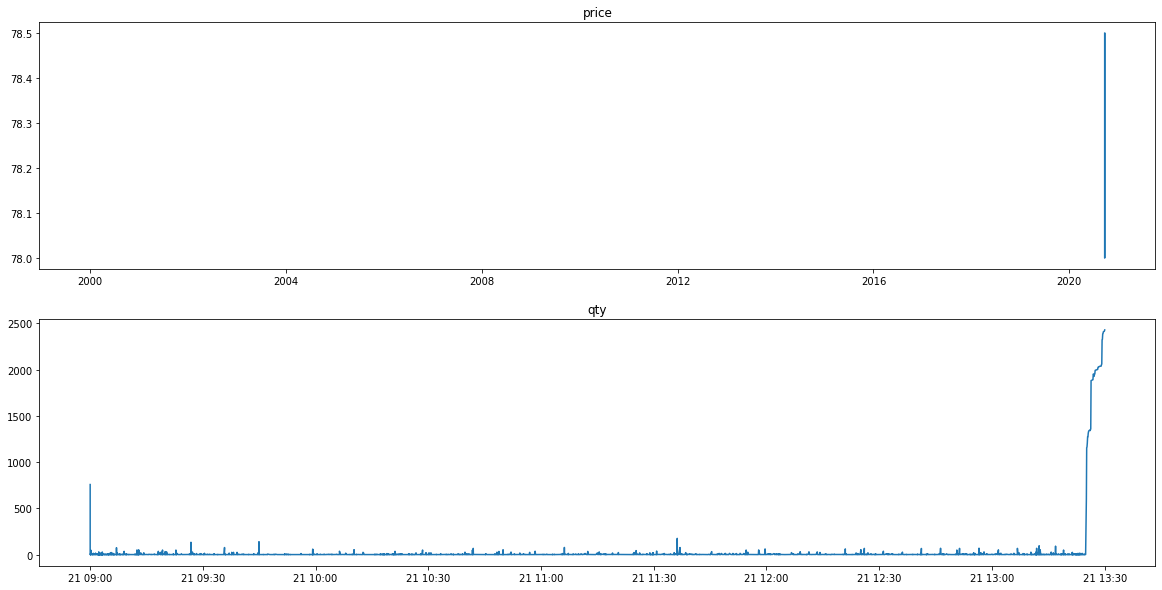

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90003102
*** bid1_p:  79.1
*** weighted_p:  78.88763171098844
ask1_p:  79.2
進場時間： 95636869 
  sell price at  79.1
*** bid1_p:  79.2
*** weighted_p:  78.93675948822708
ask1_p:  79.3
進場時間： 95826240 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.94914534341653
ask1_p:  79.3
進場時間： 100121136 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.95114150555318
ask1_p:  79.3
進場時間： 100221363 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.96737927085277
ask1_p:  79.3
進場時間： 101043296 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.97058934287281
ask1_p:  79.3
進場時間： 101144284 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.97123544874151
ask1_p:  79.3
進場時間： 101244286 
  sell

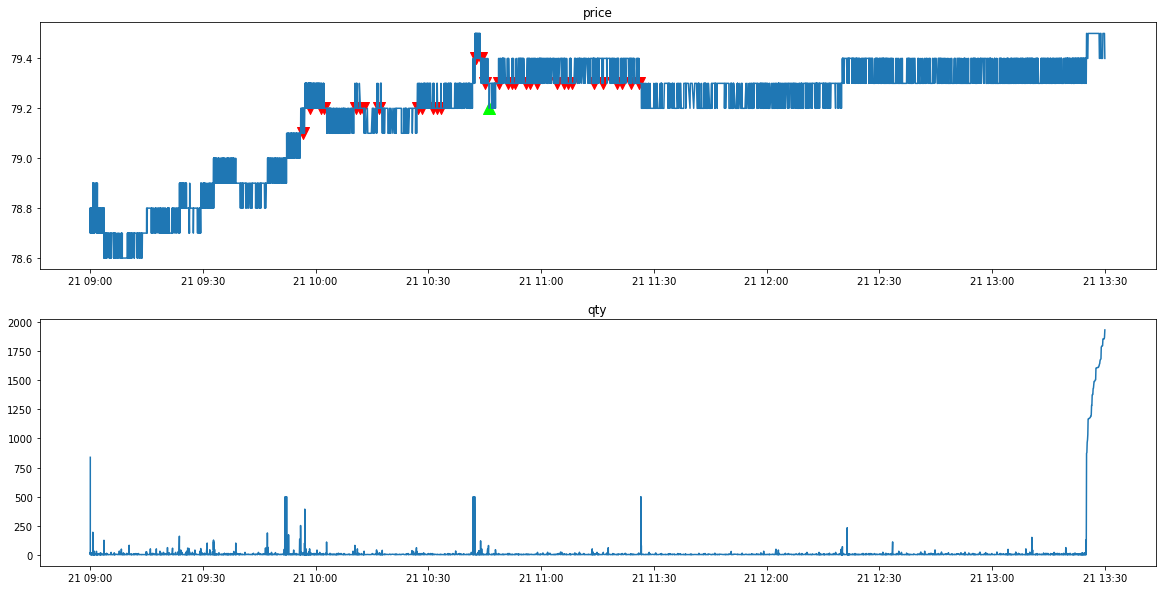

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90001658
clear_position:  0.0
position:  []
tick_row_price 79.1
----------Result Report--------------
profit:  0.0


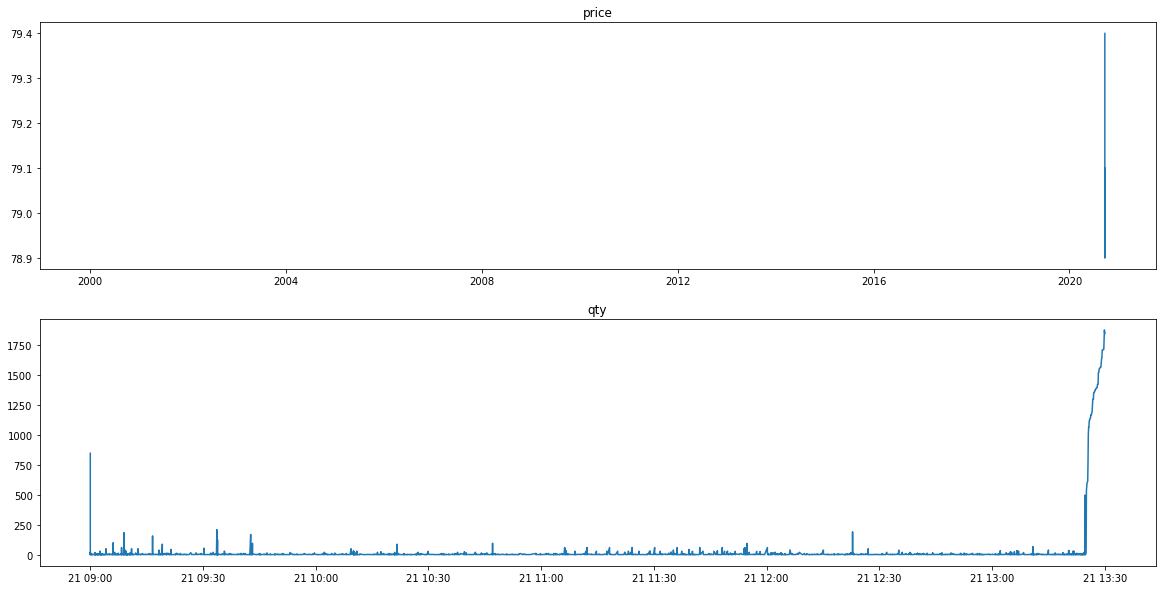

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002705
clear_position:  0.0
position:  []
tick_row_price 78.7
----------Result Report--------------
profit:  0.0


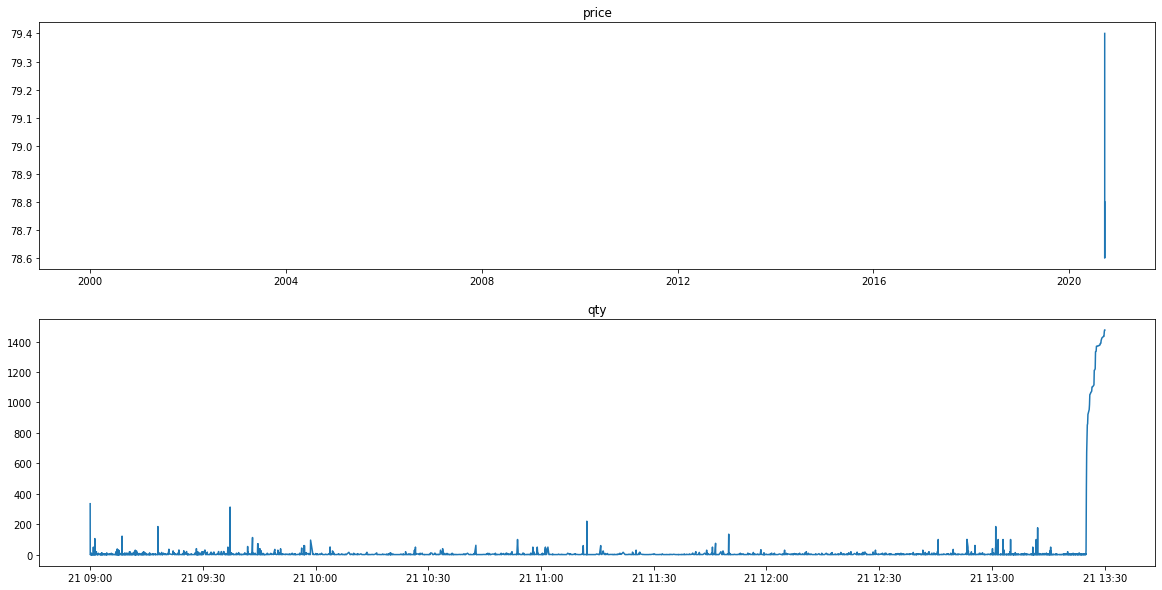

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002344
------Weird price!!!!!---------
At time:  90108814
tick_row_price 78.6
ask_1_p 78.7
bid_1_p 78.5
clear_position:  0.0
position:  []
tick_row_price 78.0
----------Result Report--------------
profit:  0.0


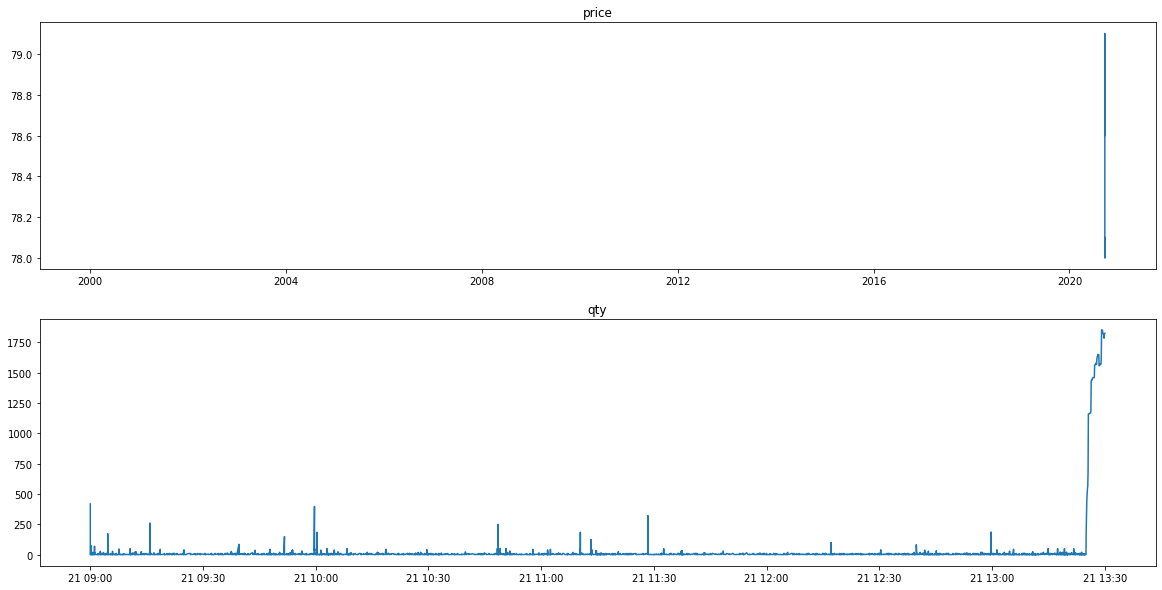

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002663
*** bid1_p:  78.0
*** weighted_p:  77.7998262114094
ask1_p:  78.1
進場時間： 110643962 
  sell price at  78.0
*** bid1_p:  78.1
*** weighted_p:  77.80985636453745
ask1_p:  78.2
進場時間： 111356233 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.81028786230145
ask1_p:  78.2
進場時間： 111457212 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.8111187845309
ask1_p:  78.2
進場時間： 111557614 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.81164187924801
ask1_p:  78.2
進場時間： 111657786 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.81376712328816
ask1_p:  78.2
進場時間： 111758217 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.81396303901485
ask1_p:  78.2
進場時間： 111859139 
  sell

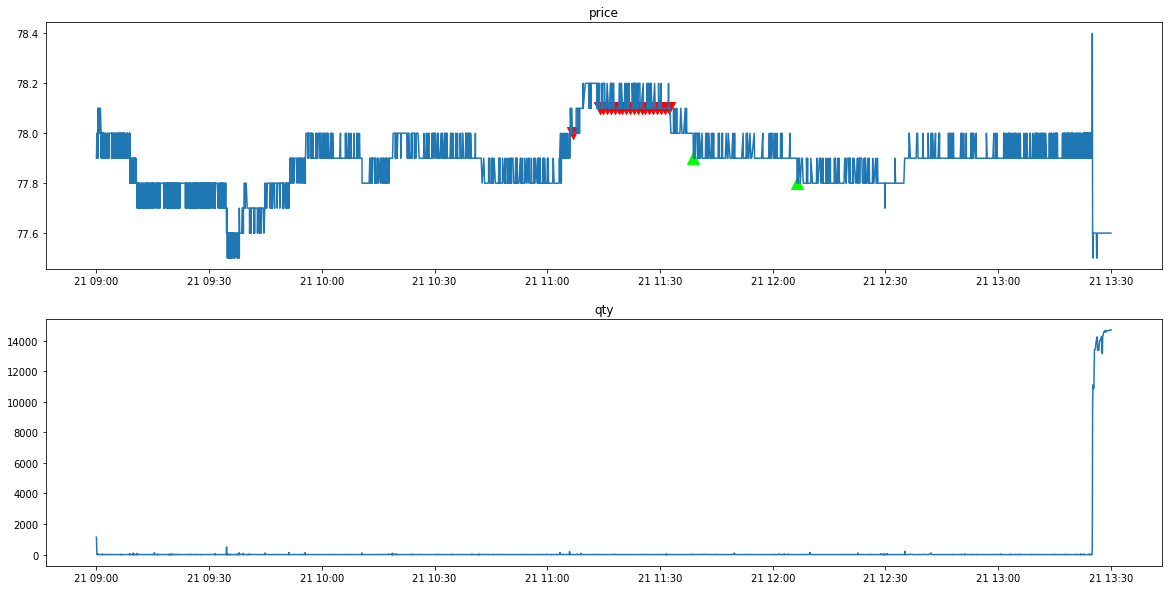

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002368
*** bid1_p:  78.2
*** weighted_p:  77.85688461538453
ask1_p:  78.3
進場時間： 92610580 
  sell price at  78.2
*** bid1_p:  78.1
*** weighted_p:  77.90194078947378
ask1_p:  78.2
進場時間： 93212355 
  sell price at  78.1
stop profit
出場時間： 93228626
POSITION(pre):  [78.2 78.1]
Order_p(pre):  [78.  77.9]
tick_row price:  78.0
qualified index:  [[0]]
POSITION(post):  [78.1]
Order_p(post):  [77.9]

stop profit
出場時間： 93736321
POSITION(pre):  [78.1]
Order_p(pre):  [77.9]
tick_row price:  77.9
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 77.5
----------Result Report--------------
profit:  0.3999999999999915


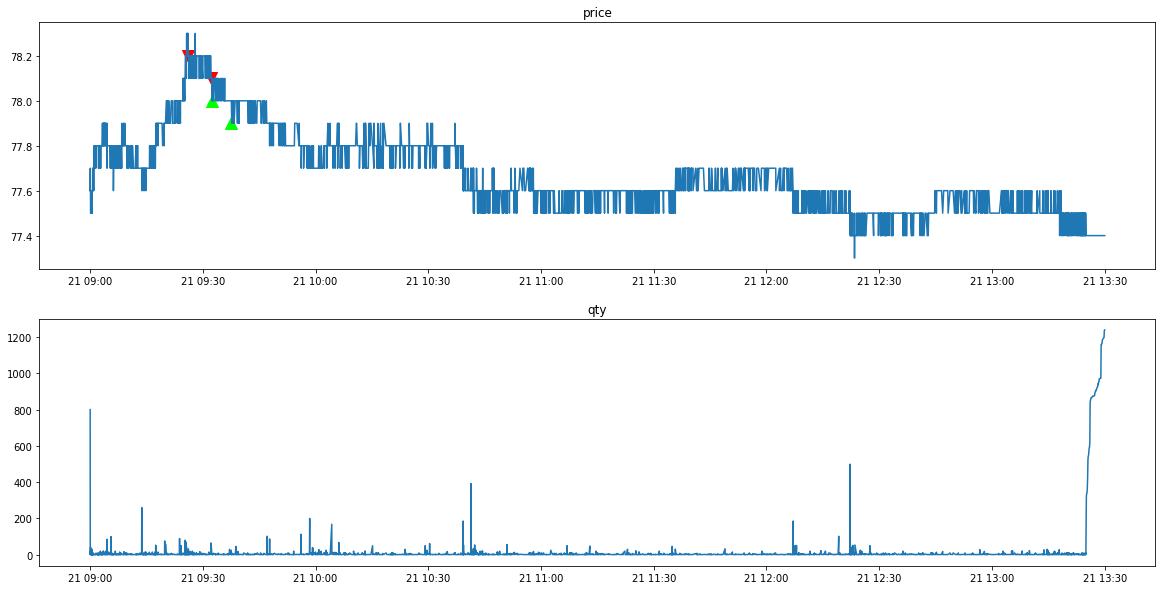

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002615
*** bid1_p:  77.1
*** weighted_p:  76.88306955842098
ask1_p:  77.2
進場時間： 95014472 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88342762387796
ask1_p:  77.2
進場時間： 95114651 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88371164149991
ask1_p:  77.2
進場時間： 95215149 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88491609273413
ask1_p:  77.2
進場時間： 95515733 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.885091120589
ask1_p:  77.2
進場時間： 95616369 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88665574718141
ask1_p:  77.2
進場時間： 95808357 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88700461716003
ask1_p:  77.2
進場時間： 95909265 
  sell price 

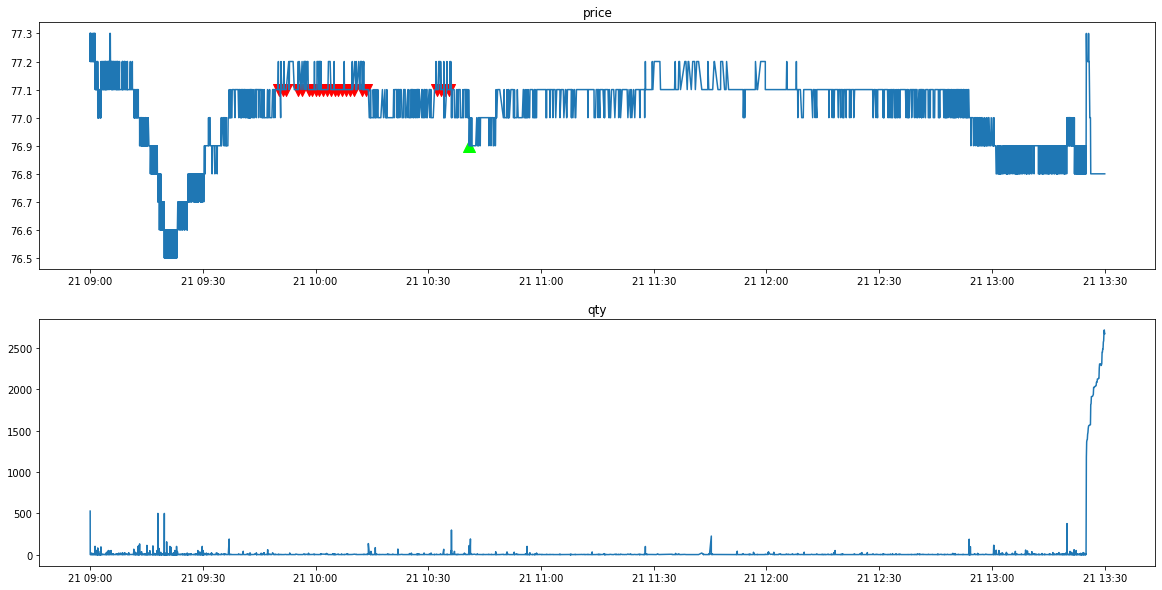

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002377
clear_position:  0.0
position:  []
tick_row_price 76.9
----------Result Report--------------
profit:  0.0


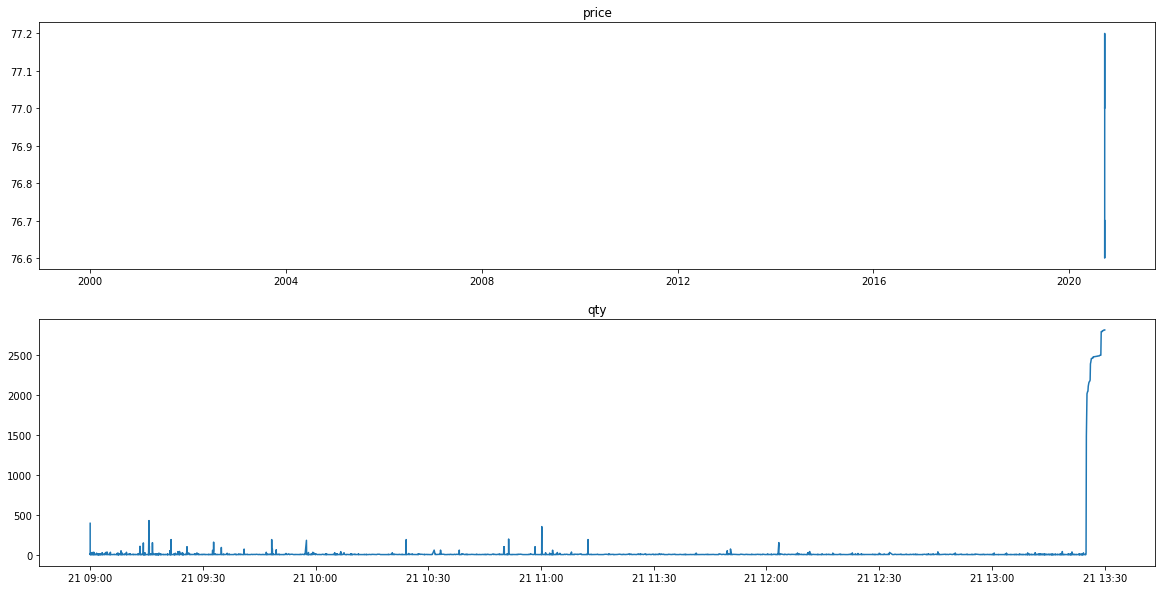

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002699
clear_position:  0.0
position:  []
tick_row_price 75.0
----------Result Report--------------
profit:  0.0


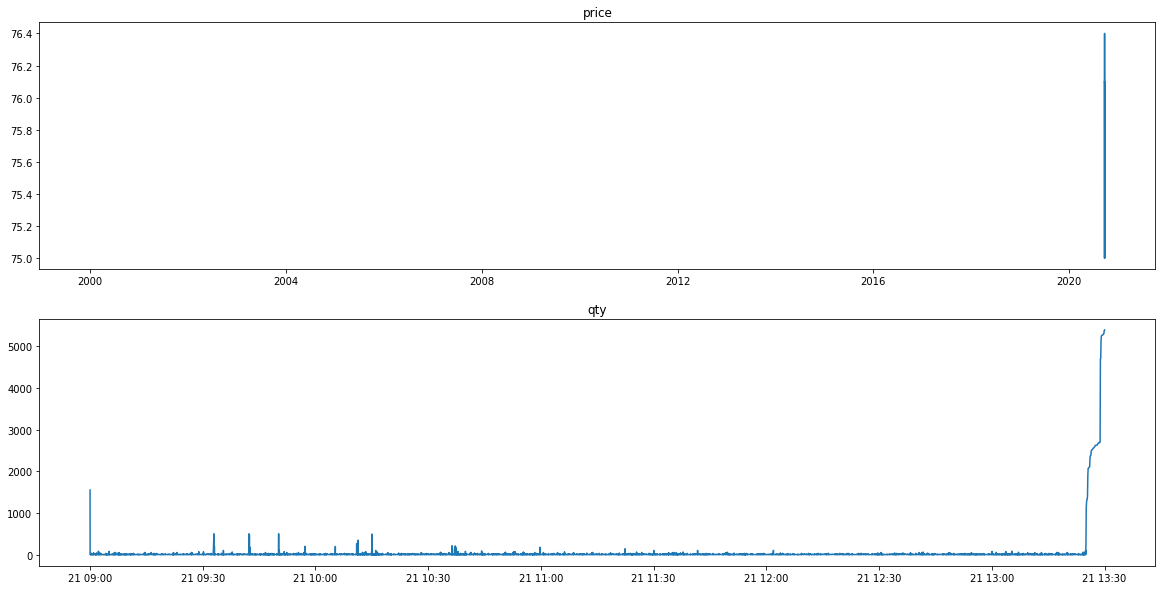

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90001647
clear_position:  0.0
position:  []
tick_row_price 74.3
----------Result Report--------------
profit:  0.0


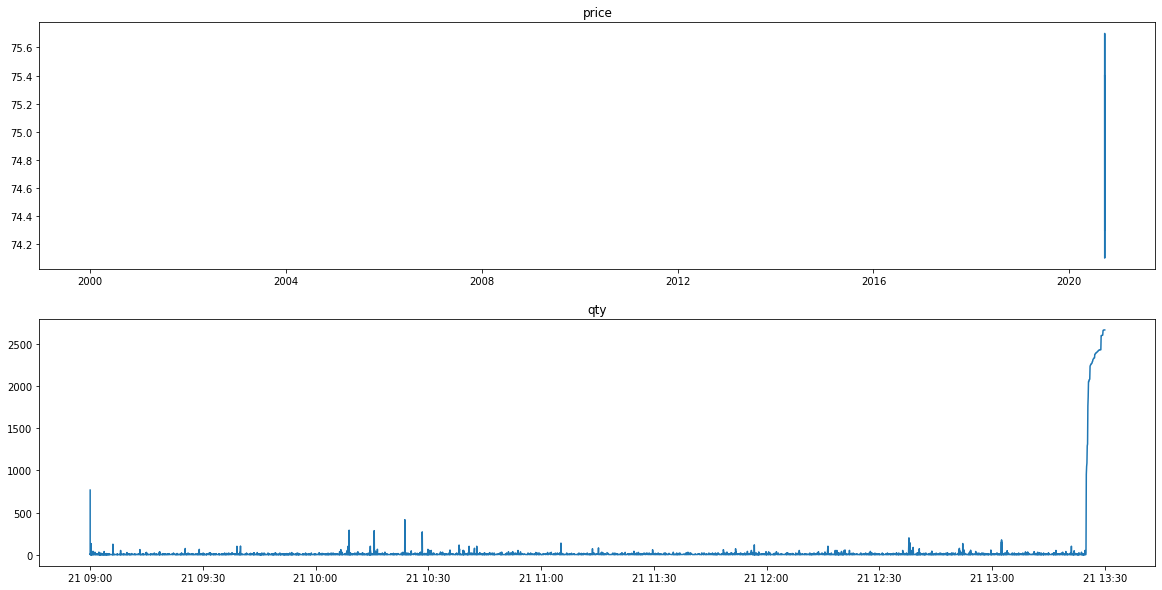

In [ ]:
para = {"sid": "2317", "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": 100000, "stop_loss_factor": 1.02, "theta": 1.0025, "position_max_q": 10}

res_2317 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
profit_2317, cost_2317 = calculate_profit(res_2317)

In [ ]:
profit_2317

6.499999999999247

In [ ]:
cost_2317

6884.1

### 2912

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90019533
clear_position:  0.0
position:  []
tick_row_price 266.0
----------Result Report--------------
profit:  0.0


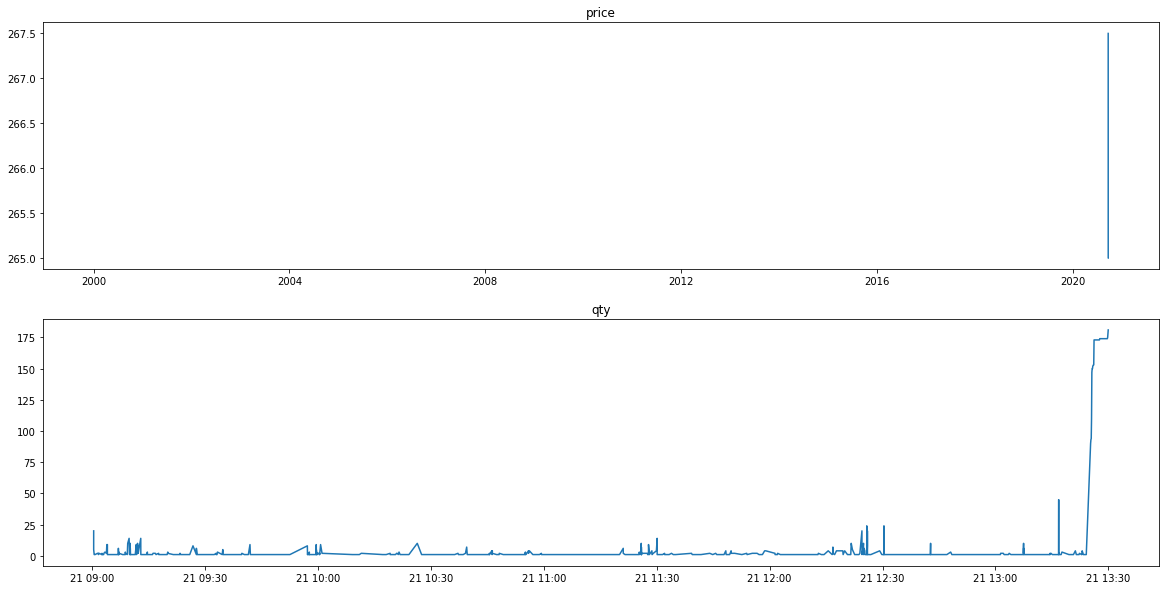

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90016905
*** bid1_p:  265.5
*** weighted_p:  264.2337770382695
ask1_p:  266.0
進場時間： 113123032 
  sell price at  265.5
*** bid1_p:  265.5
*** weighted_p:  264.2483552631579
ask1_p:  266.0
進場時間： 113224167 
  sell price at  265.5
*** bid1_p:  265.5
*** weighted_p:  264.25245901639346
ask1_p:  266.0
進場時間： 113343913 
  sell price at  265.5
*** bid1_p:  265.5
*** weighted_p:  264.3532110091743
ask1_p:  266.0
進場時間： 114451153 
  sell price at  265.5
*** bid1_p:  265.5
*** weighted_p:  264.3897928994083
ask1_p:  266.0
進場時間： 115750008 
  sell price at  265.5
*** bid1_p:  265.5
*** weighted_p:  264.3914327917282
ask1_p:  266.0
進場時間： 115859824 
  sell price at  265.5
*** bid1_p:  265.5
*** weighted_p:  264.4354609929078
ask1_p:  266.0


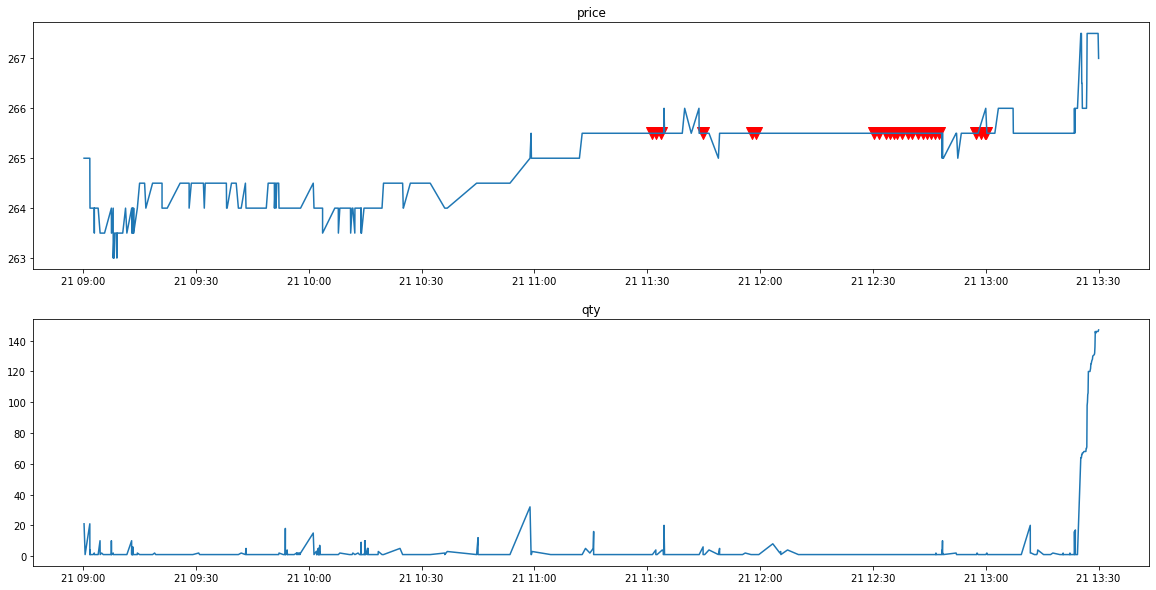

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90020184
clear_position:  0.0
position:  []
tick_row_price 265.5
----------Result Report--------------
profit:  0.0


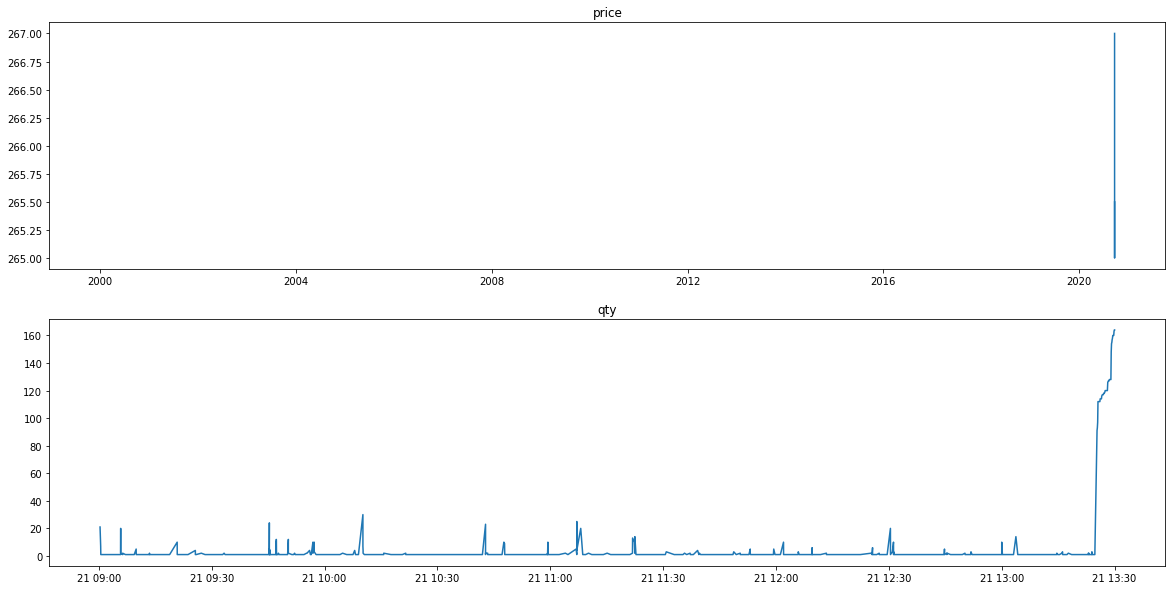

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90019794
clear_position:  0.0
position:  []
tick_row_price 267.0
----------Result Report--------------
profit:  0.0


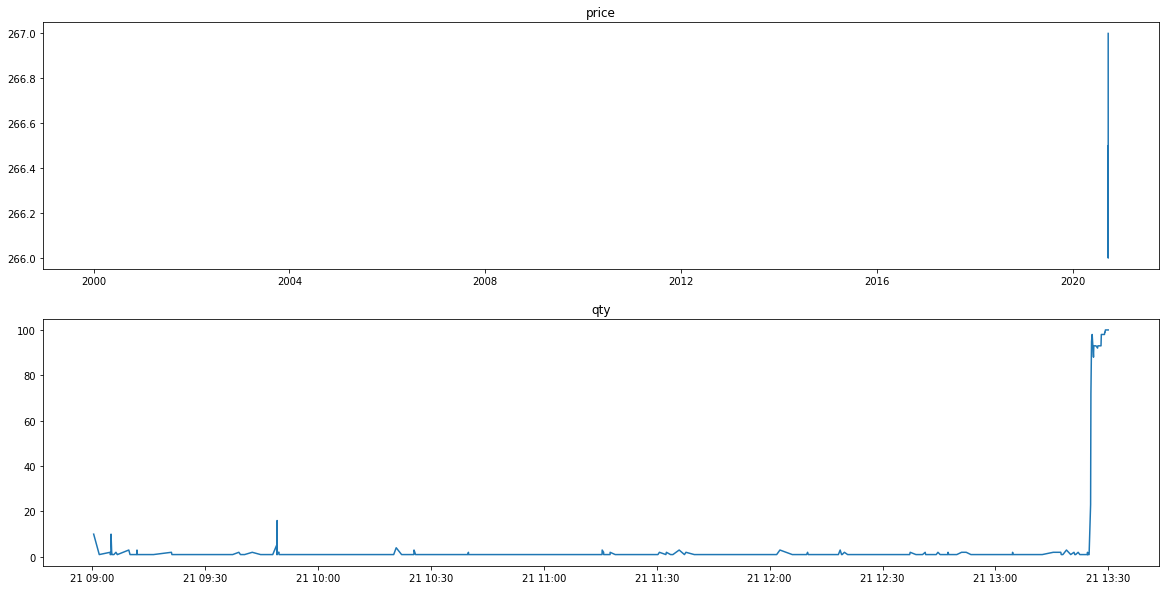

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90023121
clear_position:  0.0
position:  []
tick_row_price 266.0
----------Result Report--------------
profit:  0.0


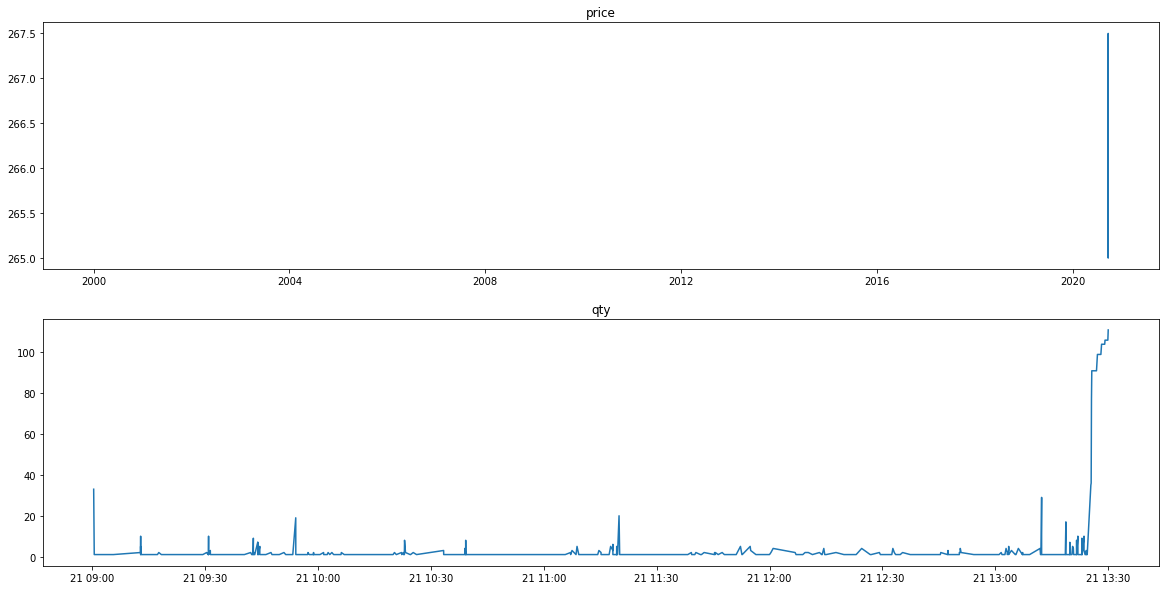

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90018175
*** bid1_p:  266.0
*** weighted_p:  265.18284789644014
ask1_p:  266.5
進場時間： 94727824 
  sell price at  266.0
*** bid1_p:  266.0
*** weighted_p:  265.18709677419355
ask1_p:  266.5
進場時間： 94838069 
  sell price at  266.0
*** bid1_p:  266.0
*** weighted_p:  265.18709677419355
ask1_p:  266.5
進場時間： 94941594 
  sell price at  266.0
stop profit
出場時間： 95456124
POSITION(pre):  [266. 266. 266.]
Order_p(pre):  [265. 265. 265.]
tick_row price:  265.0
qualified index:  [[0]
 [1]
 [2]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 265.5
----------Result Report--------------
profit:  3.0


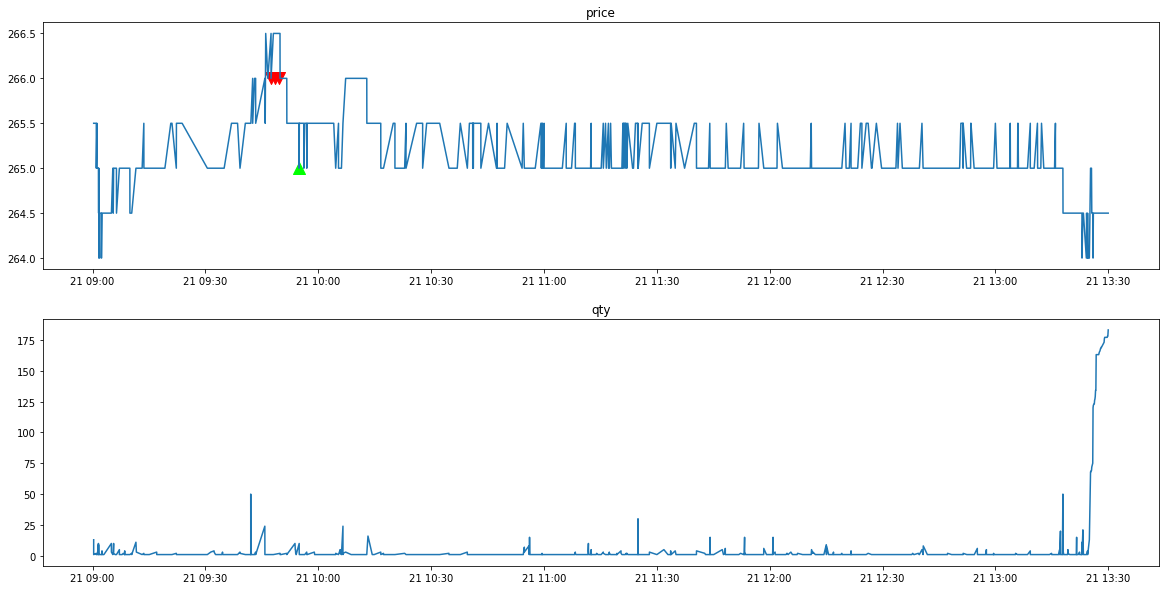

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90017851
clear_position:  0.0
position:  []
tick_row_price 264.0
----------Result Report--------------
profit:  0.0


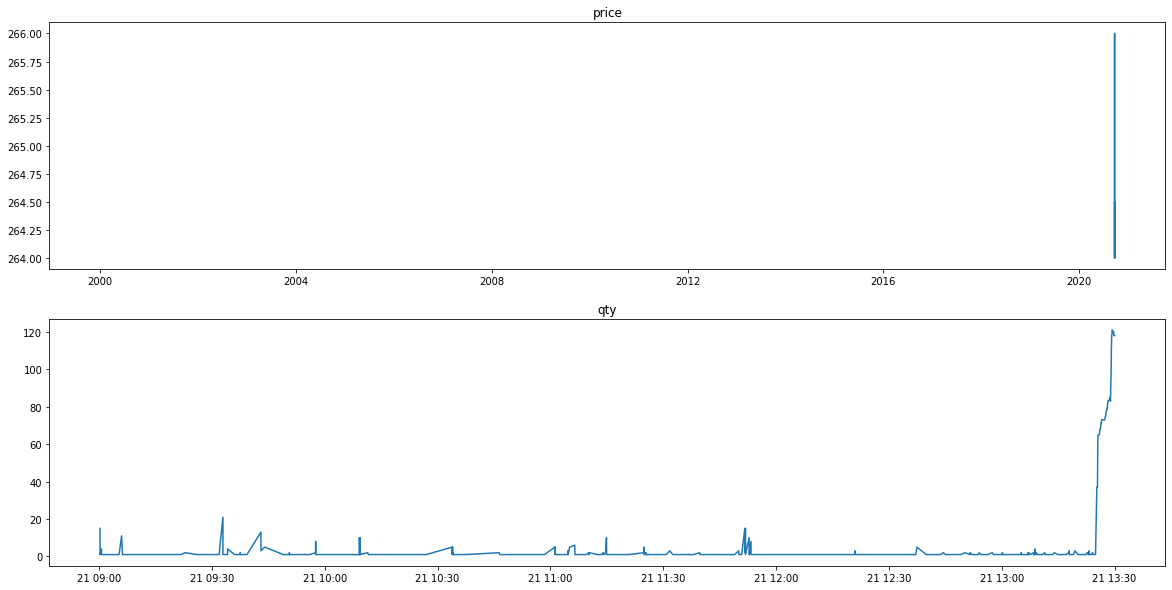

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90020530
clear_position:  0.0
position:  []
tick_row_price 264.5
----------Result Report--------------
profit:  0.0


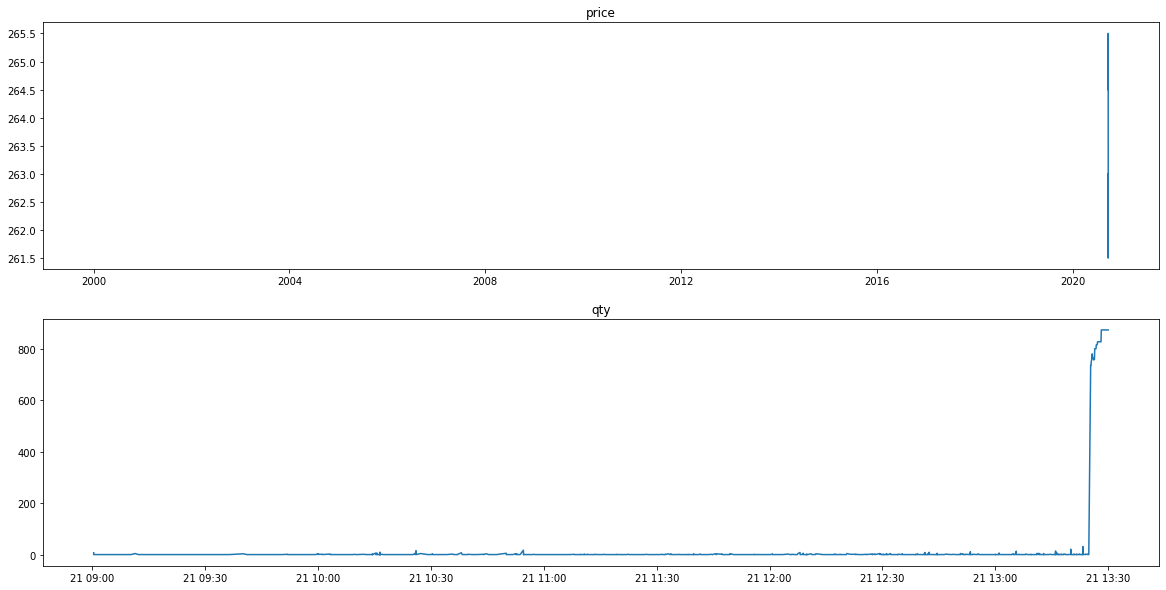

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90019505
*** bid1_p:  265.0
*** weighted_p:  264.1971962616822
ask1_p:  265.5
進場時間： 125018559 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.203531598513
ask1_p:  265.5
進場時間： 125121046 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.203531598513
ask1_p:  265.5
進場時間： 125228322 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.20593692022265
ask1_p:  265.5
進場時間： 125335736 
  sell price at  265.0
clear_position:  -2.0
position:  [265. 265. 265. 265.]
tick_row_price 265.5
----------Result Report--------------
profit:  -2.0


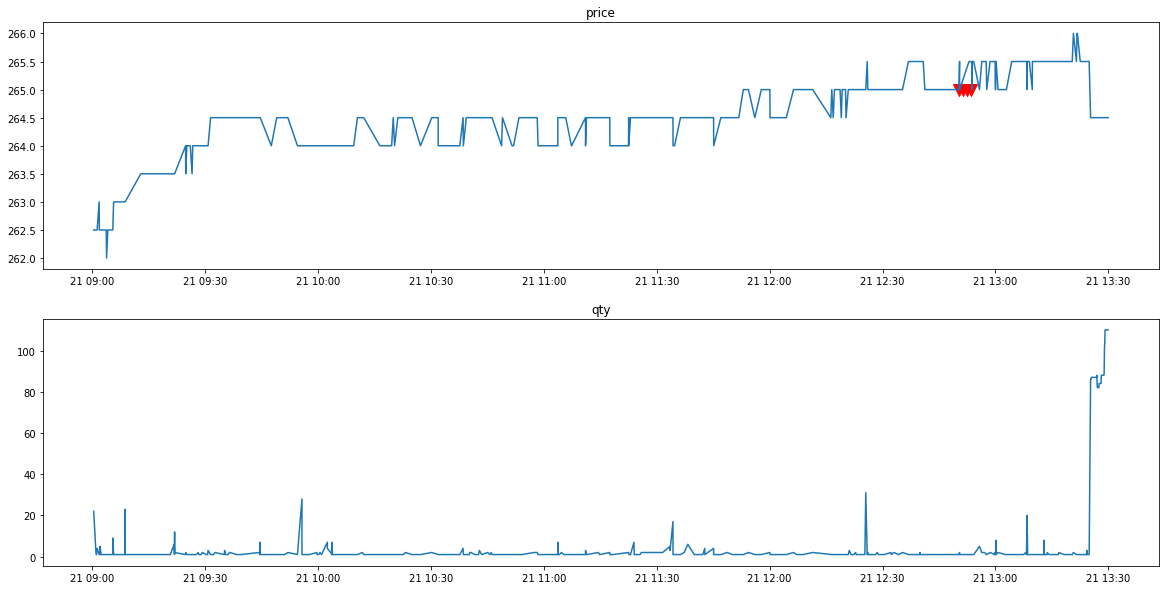

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90020075
clear_position:  0.0
position:  []
tick_row_price 265.0
----------Result Report--------------
profit:  0.0


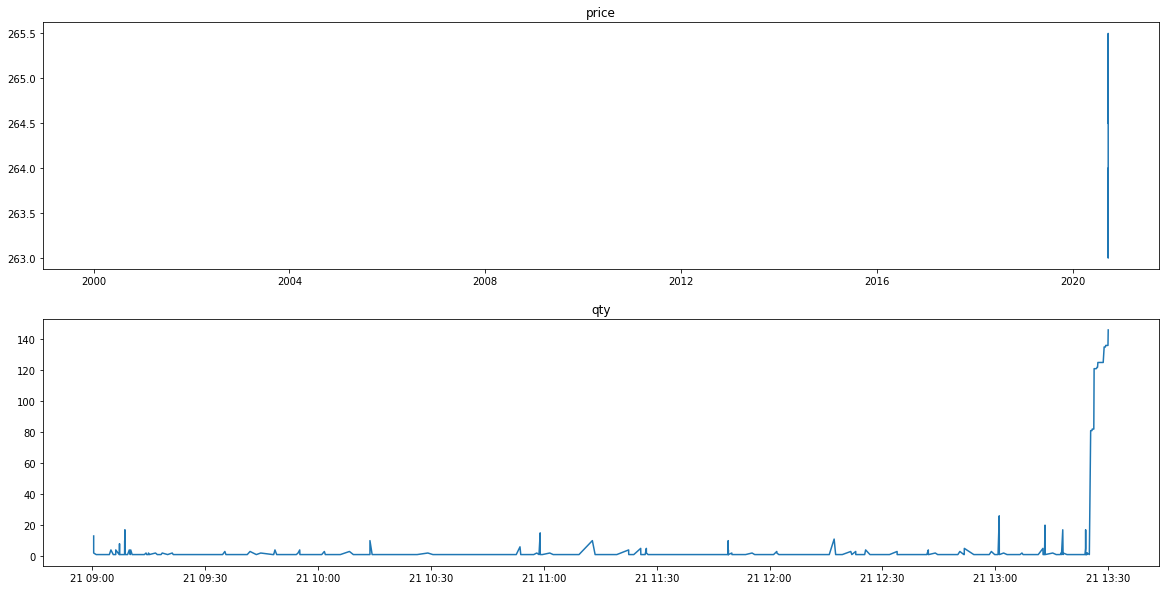

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90019430
clear_position:  0.0
position:  []
tick_row_price 261.5
----------Result Report--------------
profit:  0.0


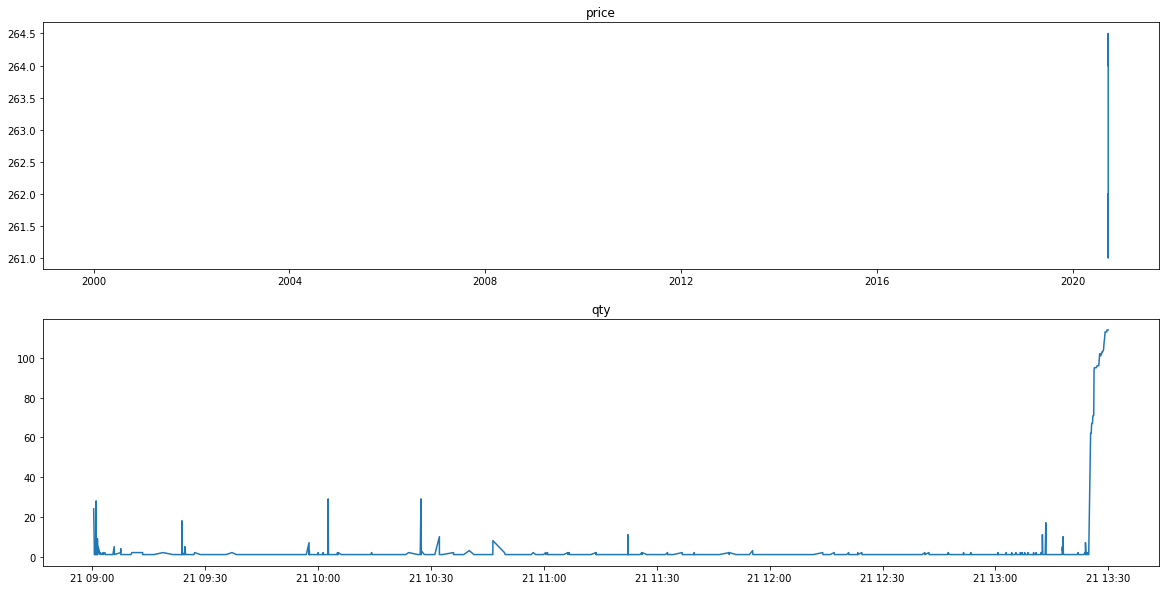

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90016123
clear_position:  0.0
position:  []
tick_row_price 254.0
----------Result Report--------------
profit:  0.0


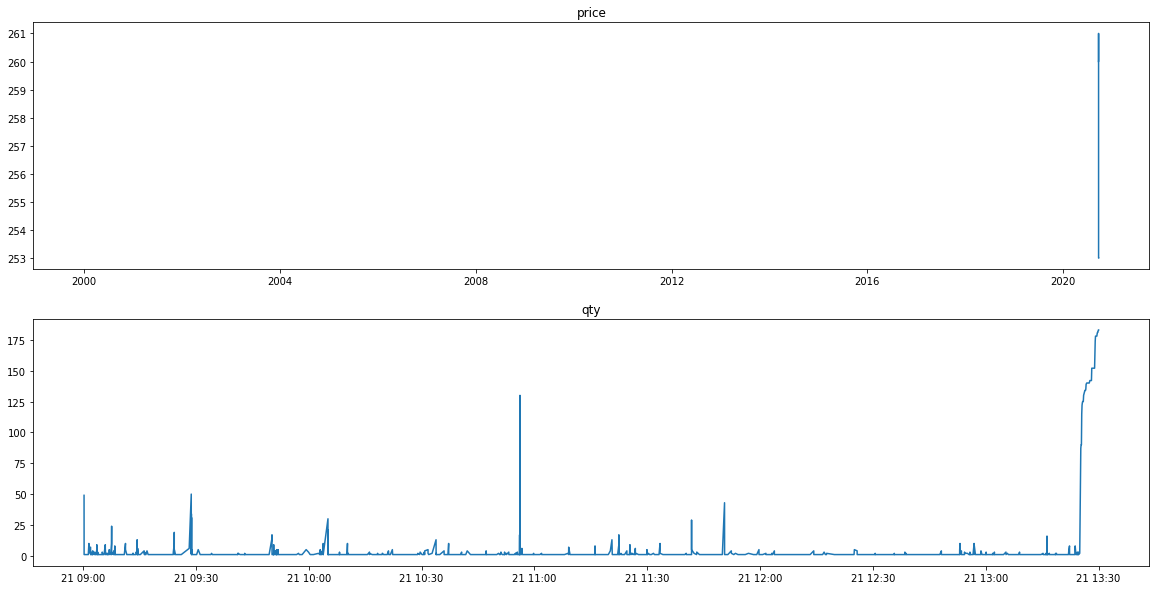

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90011747
*** bid1_p:  258.0
*** weighted_p:  256.65647163120565
ask1_p:  258.5
進場時間： 123820389 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.6597345132743
ask1_p:  258.5
進場時間： 123922561 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.6613616268789
ask1_p:  258.5
進場時間： 124030253 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.75083612040135
ask1_p:  258.5
進場時間： 124835381 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.7518796992481
ask1_p:  258.5
進場時間： 124935548 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.76732673267327
ask1_p:  258.5
進場時間： 125036573 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.7730263157895
ask1_p:  258.

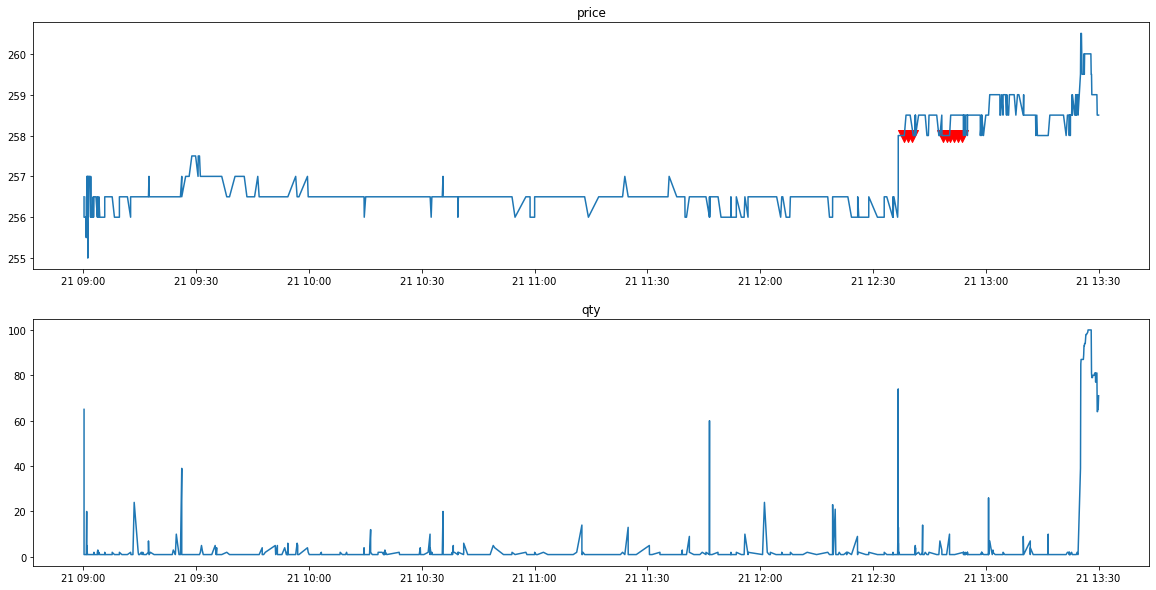

In [ ]:
para = {"sid": "2912", "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": 100000, "stop_loss_factor": 1.02, "theta": 1.0025, "position_max_q": 10}

res_2912 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
profit_2912, cost_2912 = calculate_profit(res_2912)

In [ ]:
profit_2912

-16.0

In [ ]:
cost_2912

10817.5